# Pseudorange Analysis Applied Project

## Importing the libraries

In [1]:
# Use the georinex library to get read the rinex files
import georinex as gr
# Use the 3-D geographic coordinate converions
import pymap3d as pm
# Importing other libraries for computing
import numpy as np
import matplotlib.pyplot as mpl
import seaborn as sb
%matplotlib notebook
from mpl_toolkits import mplot3d
import pandas as pd
import copy
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis

from IPython import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#display.set_matplotlib_formats("svg")

## Getting the nav and obs files from a RINEX

In [2]:
# Rinex3 files
folderName = !pwd
folderName = folderName[0]+"/Data/"
obsName, navName = ("TLSE00FRA_R_20222660000_01D_30S_MO.rnx","TLSE00FRA_R_20222660000_01D_GN.rnx")
obsFile, navFile = (folderName + obsName, folderName + navName)

#OPTIONS: Time bounds --tlim start stop 2017-02-23T12:00, meas=['C1C', 'L1C'], use='E'
# loading the GPS obs, nav files
obs = gr.load(obsFile, use='G', fast=True)
nav = gr.load(navFile, use='G', fast=True)

## Converting obs and nav files to DataFrames, just in case :-)

In [3]:
# obs and nav xarrays converted to DataFrames
obs_df = obs.to_dataframe()
nav_df = nav.to_dataframe()

## Get the satellite_positions object 

In [4]:
#from pseudodistance_generation import SatPosition, Pseudodistances, load_keplerian_elements, distance
from pseudodistance_generation import read_satellite_position, generate_pseudodistances, euclidian_distance
# SP3 filepath of 
SP3_FILEPATH = "/home/vlad/ENAC/Pseudorange/WUM0MGXULA_20201010000_01D_05M_ORB.SP3"
satellite_positions = read_satellite_position(SP3_FILEPATH)

In [5]:
satellite_positions.epoch_end

'10/4/2020 at 23:55:0'

In [6]:
satellite_positions.epochs[0]

{'time': 1270425618,
 'G01': [21720304.817, 14250409.809, 6115627.004, -105590.04373380508],
 'G02': [-9560726.388999999, -20504638.248, 14605426.568, -130774.06599798113],
 'G03': [13806771.541, 6906469.551, 21564980.188, -42070.22339039128],
 'G04': [23540862.065, 2035449.161, 12169067.024, -22060.53980608632],
 'G05': [-3229099.099, -24145042.251, -10475868.652999999, -3155.005934840886],
 'G06': [994036.007, -17308250.746000003, 20164016.576, -74573.81732054538],
 'G07': [18686465.195, -872338.642, -18740386.373, -76252.5078872485],
 'G08': [15383011.803, 9034843.694, -19739544.599, -8988.939286822291],
 'G09': [25504975.283, -7120258.740999999, 2143954.549, -58122.899254138334],
 'G10': [-11552922.348, 21578451.831, -9929246.334999999, -91189.3616185838],
 'G11': [21235987.531999998, 13129758.258, -9098367.8, -93112.45588812421],
 'G12': [-12157076.149, -9675835.765, 21331469.03, 39396.5963039082],
 'G13': [-6913211.894, -13874602.818, -21696086.04, 183.74519584786398],
 'G14': [-

## Generate and plot pseudodistances

In [7]:
# Getting the receiver epochs in GPS time
rx_epochs = np.array([sat_pos["time"] for sat_pos in satellite_positions.epochs], np.float64)
# approximative location of the Receiver in ECEF for all epochs
user_positions = np.tile(obs.position, (satellite_positions.nb_epochs,1))
# converted to LLA => RxLLA  = pm.ecef2geodetic(RxECEF[0], RxECEF[1], RxECEF[2])

#pseudodistances = generate_pseudodistances(user_positions,rx_epochs,satellite_positions)

## No corruption assumptions on the pseudorange model

In [8]:
pseudoranges = np.array([euclidian_distance(user_positions[epoch], satellite_positions, rx_epochs[epoch]) 
    for epoch in range(satellite_positions.nb_epochs)])

In [9]:
pseudoranges[0]

{'G01': {'distance': 22382132.09915146,
  'tx_time': Decimal('1270425617.92534119073'),
  'pos': array([21824121.73963474, 14412546.48175519,  5353307.75765859]),
  'vel': array([  398.98204846,   605.35458116, -3099.12987066]),
  'clock': -105872.9314248462},
 'G03': {'distance': 20696827.034731116,
  'tx_time': Decimal('1270425617.93096278886'),
  'pos': array([13656997.21699037,  7583380.54899849, 21435403.4133744 ]),
  'vel': array([-564.99217281, 2673.9250605 , -574.63623666]),
  'clock': -42348.39147775502},
 'G04': {'distance': 20489984.608435698,
  'tx_time': Decimal('1270425617.93165276210'),
  'pos': array([23187749.20714599,  2197992.17599555, 12802121.23831254]),
  'vel': array([-1483.23904003,   696.93092149,  2566.12158438]),
  'clock': -22193.67538348384},
 'G06': {'distance': 23649598.14624108,
  'tx_time': Decimal('1270425617.92111349458'),
  'pos': array([  1461014.35298936, -16918066.84104446,  20466196.95733645]),
  'vel': array([2008.36637879, 1625.48017522, 1207.8

In [10]:
prn = ["G0"+str(i) if i<10 else "G"+str(i) for i in range(1,32)]
int_prn = [np.int32(n_sat[1:3]) for n_sat in prn]
prn_dict = {}
for G in prn:
    distance, tx_time, pos, vel, clock = [], [], [], [], []
    for pr in pseudoranges:
        if G in pr:
            distance.append(pr[G]["distance"])
            tx_time.append(pr[G]["tx_time"])
            pos.append(pr[G]["pos"])
            vel.append(pr[G]["vel"])
            clock.append(pr[G]["clock"])
            continue
    #np.array(tx_time)-pseudoranges[0]["G01"]["tx_time"]  used for scaling, because time_tx is the time in s elapsed from GPS starte, 01/06/1980
    prn_dict[G]= {"distance": np.array(distance), "tx_time":  np.array(tx_time)-pseudoranges[0]["G01"]["tx_time"] , 
                      "pos": np.array(pos), "vel": np.array(vel), "clock": np.array(clock)}
prn_dict

{'G01': {'distance': array([22382132.09915146, 22411037.55491757, 22581734.80247605,
         22757409.63298803, 22937809.79628984, 23122671.42625989,
         23311719.75379781, 23504669.84033585, 23701227.34650223,
         23901089.30661563, 24103944.92199516, 24309476.35445765,
         24517359.52581191, 24727264.90986668, 24938858.32017789,
         25151801.68691336, 25365753.82040429, 25580371.16476132,
         25795308.52671921, 26010219.79568653, 25506316.93836579,
         25306319.03292541, 25108046.08796279, 24911698.92199111,
         24717471.61354041, 24525551.36714529, 24336118.4209265 ,
         24149345.99457854, 23965400.28437591, 23784440.51126843,
         23606618.99872672, 23432081.31529466, 23260966.4510479 ,
         23093407.04256413, 22929529.63592424, 22769455.00024728,
         22613298.46580935, 22461170.30717947, 22313176.14931342,
         22169417.40608235, 22029991.73256123, 21894993.49588322,
         21764514.25926831, 21638643.26510418, 21517467.9

<IPython.core.display.Javascript object>


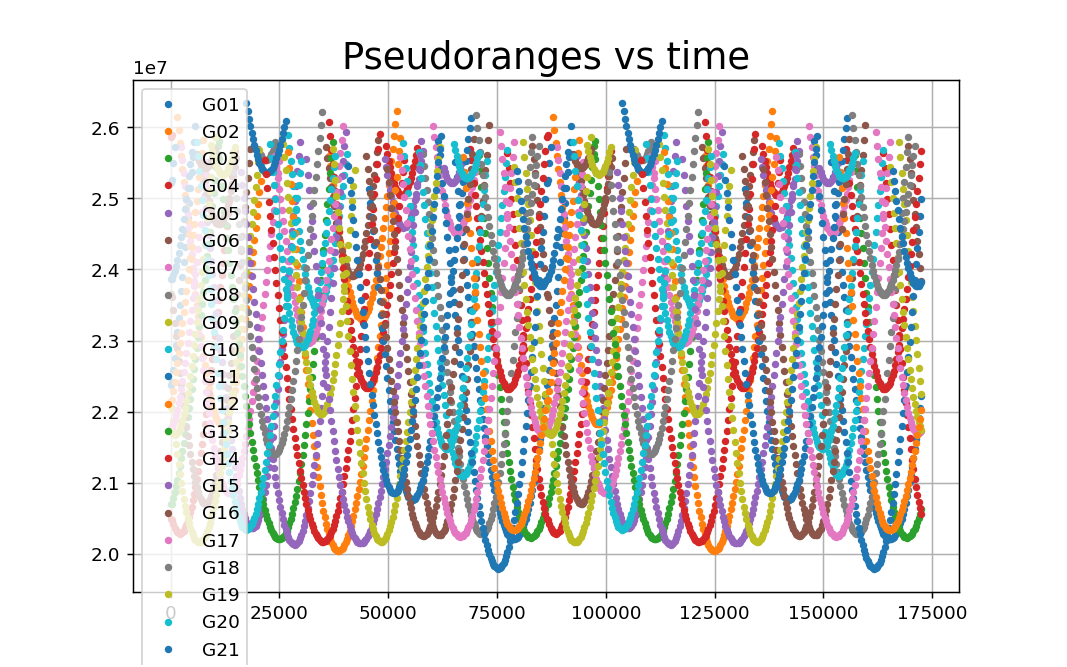

In [11]:
#n_half = int(len(prn_dict[G]["tx_time"])/2)
seconds_in_day = np.linspace(0,3600*24,satellite_positions.nb_epochs)
fig, ax = mpl.subplots(figsize=(8,5))
for G in prn_dict:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(prn_dict[G]["tx_time"][:], prn_dict[G]["distance"][:], '.', linewidth=1, label=G, color=color)
#ax.set_xlim([0, 1000000])
ax.set_title("Pseudoranges vs time", size=20)
mpl.legend(loc='best')
mpl.grid()
mpl.show()

## TROPO, IONO corrections added to the pseudorange model
chapter 7.1.3
STICK TO ONE SATELLITE FOR NOW
1. how to generate AR MODEL => add random walk, AR model to the pseudorange
2. look for elevation and azimuth


In [12]:
ECEF_sat_pos = {}
for G in prn:
    temp = []
    visible = True
    for sat_pos in satellite_positions.epochs:
        #if sat_pos.get(G)!=None:
        if G in sat_pos:
            temp.append(sat_pos[G])
            continue
        else:
            visible = False
    if visible:
        ECEF_sat_pos[G]=np.array(temp)

print("Satellite Positions in ECEF frame:")
ECEF_sat_pos

Satellite Positions in ECEF frame:


{'G01': array([[21720304.817     , 14250409.809     ,  6115627.004     ,
          -105590.04373381],
        [21847247.252     , 14440366.737     ,  5189352.552     ,
          -105591.03484767],
        [21951211.096     , 14604955.705     ,  4253293.308     ,
          -105592.03045842],
        ...,
        [21509447.188     , 13959653.618     ,  7349523.147     ,
          -106151.89467249],
        [21665438.373     , 14185063.842     ,  6439223.192     ,
          -106152.86510068],
        [21800177.767     , 14384118.323     ,  5516764.349     ,
          -106153.83522907]]),
 'G02': array([[ -9560726.389     , -20504638.248     ,  14605426.568     ,
           -130774.06599798],
        [ -9100490.079     , -20224134.13      ,  15302980.325     ,
           -130774.56964931],
        [ -8615498.353     , -19936902.723     ,  15972471.645     ,
           -130775.13895519],
        ...,
        [-10149158.91      , -20872936.421     ,  13610609.137     ,
           -131106.368

In [13]:
aer_sat_pos = {}
for G in prn:
    i = 0
    aer = []
    if G in ECEF_sat_pos:
        for pos in ECEF_sat_pos[G][:,:3]:
            lat,lon,h = pm.ecef2geodetic(user_positions[i][0],user_positions[i][1],user_positions[i][2])
            az, el, srange = pm.ecef2aer(x=pos[0],y=pos[1],z=pos[2],lat0=lat,lon0=lon,h0=h)
            aer.append([az,el,srange])
            i+=1
        aer_sat_pos[G] = np.array(aer)
print(f'(Azimuth,Elevation,Slant-Range) for each Satellite:')
aer_sat_pos

(Azimuth,Elevation,Slant-Range) for each Satellite:


{'G01': array([[1.28187680e+02, 3.84971015e+01, 2.22456135e+07],
        [1.29724239e+02, 3.64170597e+01, 2.24110951e+07],
        [1.31185846e+02, 3.43382248e+01, 2.25817941e+07],
        ...,
        [1.25955581e+02, 4.12948897e+01, 2.20316570e+07],
        [1.27603037e+02, 3.92159917e+01, 2.21897443e+07],
        [1.29167890e+02, 3.71363044e+01, 2.23533505e+07]]),
 'G02': array([[ 3.10924041e+02, -7.67768044e+00,  2.70440255e+07],
        [ 3.11598399e+02, -5.96877217e+00,  2.68663572e+07],
        [ 3.12225822e+02, -4.24553963e+00,  2.66870594e+07],
        ...,
        [ 3.09933177e+02, -9.98739745e+00,  2.72833627e+07],
        [ 3.10669281e+02, -8.29833158e+00,  2.71082238e+07],
        [ 3.11360530e+02, -6.59463141e+00,  2.69311866e+07]]),
 'G03': array([[4.74316345e+01, 6.44821933e+01, 2.06368107e+07],
        [5.07699484e+01, 6.27092570e+01, 2.07082368e+07],
        [5.38701600e+01, 6.09244653e+01, 2.07847598e+07],
        ...,
        [4.25783559e+01, 6.67772801e+01, 2.05513

In [14]:
from pseudodistance_generation import tropospheric_error, ionospheric_error

fGPSL1 = 1575.42e6 # Hz
tropo_error,iono_error = {},{}
for G in prn:
    iono = []
    if G in aer_sat_pos:
        for aer in aer_sat_pos[G]:
            temp_iono = ionospheric_error(fGPSL1, aer[1])
            #temp_tropo = tropo_error(user_positions[i],aer_sat_pos[G][i,1])
            iono.append(temp_iono)
            #tropo_error.append(temp_tropo)
    #tropo_error = np.array(tropo_error)
        iono_error[G] = np.array(iono) # in meters
print(f'Ionospheric errors for each PRN: \n')

prn = list(iono_error.keys())
iono_error

Ionospheric errors for each PRN: 



{'G01': array([4.26088526, 3.36694437, 7.63740864, 4.11758307, 3.41909668,
        8.11734949, 3.90976892, 3.53775887, 8.64367945, 3.63130825,
        3.82795102, 8.08448583, 3.36087078, 4.56853269, 5.93865039,
        3.24968363, 6.60015658, 4.13174198, 3.58848134, 8.27875074,
        3.30862195, 5.43017028, 4.45316788, 3.55588676, 7.88489051,
        3.25314439, 7.04000952, 3.63578025, 4.61908184, 4.58637973,
        3.72987014, 5.9878296 , 3.41490887, 7.24096718, 3.32076463,
        7.67353546, 3.32476829, 7.11574704, 3.45044177, 5.59756438,
        3.95729392, 4.04476825, 5.9419752 , 3.27522418, 7.67147623,
        3.8682261 , 3.5847893 , 8.58370513, 3.94781105, 3.32854712,
        5.53996516, 7.50149   , 3.97737379, 3.26052528, 3.46918912,
        4.29098572, 5.64640833, 7.08966314, 7.89597646, 7.93783554,
        7.231316  , 5.8411175 , 4.44760427, 3.55331675, 3.24763134,
        3.73435807, 6.40527872, 6.7561757 , 3.56039   , 3.4724104 ,
        7.27036866, 4.58458576, 3.2835999

<IPython.core.display.Javascript object>


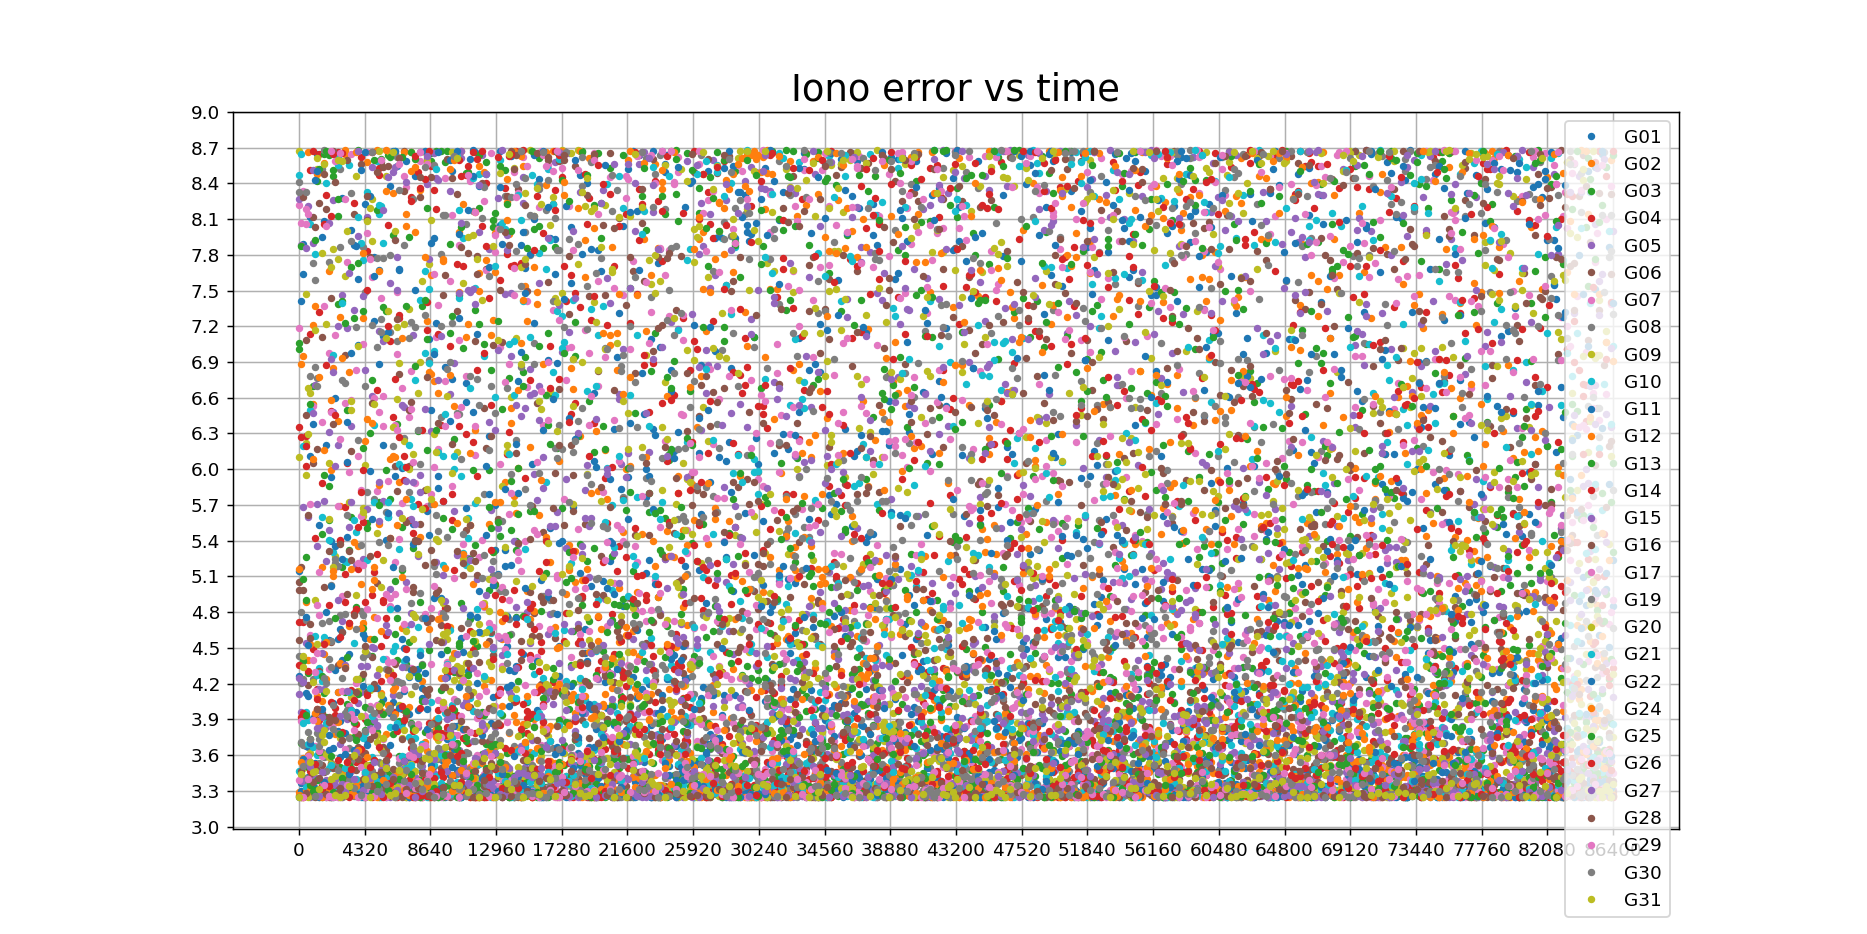

In [15]:
fig, ax = mpl.subplots(figsize=(14,7))
for G in prn:
    if G in iono_error:
        color = next(ax._get_lines.prop_cycler)['color']
        ax.plot(seconds_in_day, iono_error[G], '.', linewidth=1, label=G, color=color)
#ax.set_xlim([0, 1000000])
ax.set_title("Iono error vs time", size=20)
ax.set_yticks(np.linspace(3,9,21))
ax.set_xticks(np.linspace(min(seconds_in_day),max(seconds_in_day),21))
mpl.legend(loc='best')
mpl.grid()
mpl.show()

# Focuss on one satellite
## Generalized AR(p) model
$$x(n)=-\sum_{k=1}^{p}a_{k}x(n-k)+w(n)$$
$$w(n)\sim N(0,\sigma_{w}^{2}) \quad centered \space white\space gaussian\space noise$$
## Random Walk of AR(1)
$$x_{k}=1\cdot x_{k-1} +w(n)$$

In [16]:
def AR(p,xn,sigma_w,n):
    yn = copy.deepcopy(xn)
    w  = np.random.normal(0, sigma_w**2, (n,1))
    #ak = 2*np.transpose(np.random.rand(p,1))-1
    ak = np.ones(p) #for random walk
    for i in range(0,n):
        if i>=p:
            yn[0][i] = np.dot(ak,np.transpose(xn[:,i-p:i])) + w[i]
    return yn,ak

<IPython.core.display.Javascript object>


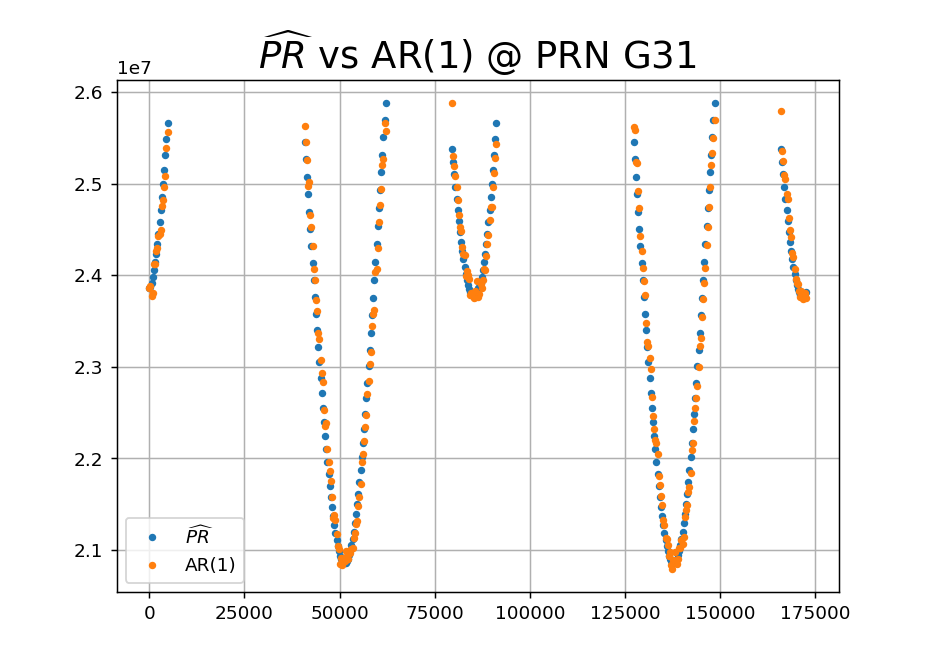

In [17]:
def corrupt_PR(n_sat, p=1, sigma_w=250):
    xn      = copy.deepcopy(prn_dict[n_sat]["distance"])
    n       = len(xn)
    xn      = xn.reshape(1,n)
    return AR(p, xn, sigma_w, n)

corrupted_prn_dict = {}
for n_sat in prn:
    yn,ak = corrupt_PR(n_sat)
    corrupted_prn_dict[n_sat] = {"distance": np.transpose(yn).flatten(), "tx_time": prn_dict[n_sat]["tx_time"]}
    
fig, ax = mpl.subplots(figsize=(7,5))
ax.plot(prn_dict[n_sat]["tx_time"], prn_dict[n_sat]["distance"], '.', linewidth=1, label=r"$\widehat{PR}$")
ax.plot(prn_dict[n_sat]["tx_time"], corrupted_prn_dict[n_sat]["distance"], '.', linewidth=1, label=f"AR(1)")
ax.set_title(r"$\widehat{PR}$"+f" vs AR({1}) @ PRN {n_sat}", size=20)
mpl.legend(loc='best')
mpl.grid()
mpl.show()

In [18]:
## sky plot - polar plot of azimuth and elevation (pi/2-elev)

## Correlator Output
Mainly the pseudorange is: $\hat{\tau}(t)$
- If the $\epsilon_{\theta}$ error is constant over the integration period, then the correlator output yields:
$$I(k)=\frac{A}{2}d(k)cos(\epsilon_{\theta})K_{c_{{m}_{f}}c_{{m}_{L}}}(\epsilon_{\tau})+n_{I}(k)$$
$$Q(k)=\frac{A}{2}d(k)sin(\epsilon_{\theta})K_{c_{{m}_{f}}c_{{m}_{L}}}(\epsilon_{\tau})+n_{Q}(k)$$
- If the $\epsilon_{\theta}$ error has a linear variation over the integration period, then the correlator output yields:
$$I(k)=\frac{A}{2}d(k)sinc(\pi\epsilon_{f_{d}}T_{I})K_{c_{{m}_{f}}c_{{m}_{L}}}(\epsilon_{\tau})cos(\epsilon_{\theta_{0}})+n_{I}(k)$$
$$Q(k)=\frac{A}{2}d(k)sinc(\pi\epsilon_{f_{d}}T_{I})K_{c_{{m}_{f}}c_{{m}_{L}}}(\epsilon_{\tau})sin(\epsilon_{\theta_{0}})+n_{Q}(k)$$
* $\epsilon_{f_{d}}$ is the doppler offset between the Doppler frequency of the useful incoming signal and and the Doppler frequency of the local carrier
* $\epsilon_{\theta_{0}}$ is the carrier phase tracking error in the middle of the integration interval

## Assumptions:
1. Perfect carrier phase estimation and doppler frequency, meaning the only variable to model is the code delay estimation error 
- $\epsilon_{\phi}=0$, $\epsilon_{f_{d}} = 0$
2. $\epsilon_{f_d}$, $\epsilon_{\phi}$, $\epsilon_{\tau}$ assumed to follow normal distributions:
- $\epsilon_{f_d} \sim \mathcal{N}(0,\sigma_{f_{d}}^{2})$ for GPS $f_{d}\in[-4.9,+4.9]KHz$
- $\epsilon_{\tau} \sim \mathcal{N}(0,\sigma^{2}_{\epsilon_{\tau}})$
- $\epsilon_{\phi} \sim \mathcal{N}(0,\sigma^{2}_{\epsilon_{\phi}})$ C/N0 at the output of the tracking loops
- $n_{I} \sim \mathcal{N}(0,\frac{N_{0}}{4Ti})$, $n_{Q} \sim \mathcal{N}(0,\frac{N_{0}}{4Ti}), independent$

In [19]:
c   = 299792458
L   = 1023
Tc  = 1e-3/L # chip duration in a PRN code
Tr  = L*Tc   # PRN code repetition period
Ti  = 20e-3 # correlator integration period
A   = 1 # amplitude of the signal
N0  = 10**(-140.72/10) # Noise floor level in W
pr1 = copy.deepcopy(prn_dict[n_sat]["distance"])
N   = pr1.shape[0] # nr of samples of the PR

tau_hat_prn1 = pr1/c # estimated code delay
nr_codes_prn1 = tau_hat_prn1/Tc # nr of PRN codes transmitted during the time propagation
delayed_bits_prn1 = (tau_hat_prn1%Tc)/(Tc/1024) # during Tc 1024 bits transmitted => how many bits transmitted in tau_hat_prn1
print(f'Estimated Time Propagation Delay:\n {tau_hat_prn1}\n')
print(f'Number of Tc periods inside the estimated time propagation delay: \n{nr_codes_prn1}\n') 
print(f'Time propagation delay expressed in number of delayed bits: \n{delayed_bits_prn1}')

Estimated Time Propagation Delay:
 [0.07958512 0.07960589 0.07978133 0.07999281 0.08023976 0.08052146
 0.08083703 0.08118547 0.08156568 0.08197643 0.0824164  0.08288417
 0.08337827 0.08389712 0.08443914 0.08500265 0.08558598 0.0849072
 0.08427275 0.08363775 0.08300298 0.08236929 0.08173754 0.08110867
 0.08048366 0.07986354 0.0792494  0.07864236 0.07804359 0.0774543
 0.07687576 0.07630924 0.07575608 0.07521763 0.07469526 0.07419037
 0.07370435 0.07323862 0.07279458 0.07237363 0.07197712 0.0716064
 0.07126278 0.0709475  0.07066177 0.07040669 0.07018332 0.06999261
 0.06983541 0.06971248 0.06962444 0.06957182 0.06955499 0.0695742
 0.06962955 0.06972104 0.06984847 0.07001154 0.07020981 0.07044268
 0.07070943 0.07100922 0.07134107 0.07170391 0.07209654 0.07251767
 0.07296593 0.07343986 0.07393793 0.07445855 0.07500006 0.07556078
 0.07613899 0.07673294 0.07734084 0.07796092 0.07859139 0.07923045
 0.07987633 0.08052726 0.08118149 0.08183728 0.08249294 0.08314679
 0.0837972  0.08444256 0.085081

In [20]:
Bl = {"Code": 30, "Phase": 1} #Hz
CN0= {"dBHz": 45, "W": 10**(45/10)} #dBHz or Watts
Cs = 1#1 chip
# Costas PLL, eps_phi variances
var_eps_phi = {"Costas": (Bl["Phase"]/CN0["W"])*(1+1/(2*CN0["W"]*Ti))} #rad^2

# EML,DP,EMLP DLL eps_tau variances
var_eps_tau = {"chip^2": {"EML" : (Bl["Code"]*Cs)/(2*CN0["W"]),
                          "DP"  : (Bl["Code"]*Cs)/(2*CN0["W"])*(1+(1/(Ti*CN0["W"]))),
                          "EMLP": (Bl["Code"]*Cs)/(2*CN0["W"])*(1+(2/(Ti*CN0["W"]*(2-Cs))))},
              "s^2":     {"EML" : (Tc**2)*(Bl["Code"]*Cs)/(2*CN0["W"]),
                          "DP"  : (Tc**2)*(Bl["Code"]*Cs)/(2*CN0["W"])*(1+(1/(Ti*CN0["W"]))),
                          "EMLP": (Tc**2)*(Bl["Code"]*Cs)/(2*CN0["W"])*(1+(2/(Ti*CN0["W"]*(2-Cs))))}}#chip^2

eps_phi = {"Costas" : np.random.normal(0, np.sqrt(var_eps_phi["Costas"]), N)}
eps_tau = {"EML"    : np.random.normal(0, np.sqrt(var_eps_tau["s^2"]["EML"]), N),
           "DP"     : np.random.normal(0, np.sqrt(var_eps_tau["s^2"]["DP"]), N),
           "EMLP"   : np.random.normal(0, np.sqrt(var_eps_tau["s^2"]["EMLP"]), N)}

eps_fd = np.zeros(N)

fdmax= 4.9e3 #Hz
fd   = np.random.normal(0,fdmax/3,N) # fd follows a normal distribution
tau  = np.random.lognormal(-2.7,1/45,N) # tau follows a lognormal distribution, -2.7 closer to 1/15
CN0  = np.random.uniform(50,60,N) #C/N0 is dBHz random values between 50 and 60 dBHz
phi  = np.array([np.random.normal(0, 10**(cn0/10)) for cn0 in CN0])%np.pi # phi[radians] follows a normal distribution dependent on C/N0
print('Doppler Frequency values drawn from a normal distribution:\n')
print(fd)
print('\nTime Delay propagation values drawn from a lognormal distribution:\n')
print(tau)
print('\nPhase Delay values drawn from a normal distribution:\n')
print(phi)

<IPython.core.display.Javascript object>


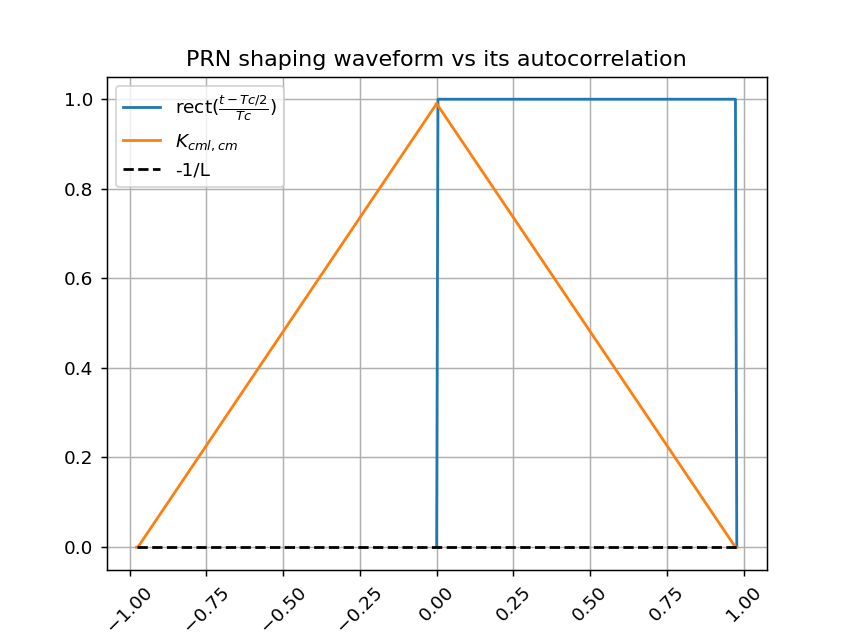

In [21]:
t = np.linspace(0, Tc, N)
copied_eps_tau = copy.deepcopy(eps_tau)

# Build the rectangular window
#rect = np.where(abs(f<=0.5), 1, 0)
rect = np.zeros(N)
rect[1:-1]=1

# Build the autocorrelation function
K = (1/N)*np.convolve(rect, rect,'full')
K[0:np.argmax(K)]-=1/L
K[np.argmax(K)+1:]-=1/L

# Method 1: Use the K_cml_cm absolute value approximative function
def K_approx_function(x):
    if np.abs(x)<Tc:
        return 1-np.abs(x)
    else:
        return 0

K_approx = np.vectorize(K_approx_function)
K_cml_cm_approx = {"EML" : K_approx(copied_eps_tau["EML"]),
                   "DP"  : K_approx(copied_eps_tau["DP"]),
                   "EMLP": K_approx(copied_eps_tau["EMLP"])}

# Method 2: Use the K_cml_cm by interpolating
K_cml_cm_interp = {"EML" : interp1d(np.linspace(-Tc,Tc,2*N-1),K)(eps_tau["EML"]),
                   "DP"  : interp1d(np.linspace(-Tc,Tc,2*N-1),K)(eps_tau["DP"]),
                   "EMLP": interp1d(np.linspace(-Tc,Tc,2*N-1),K)(eps_tau["EMLP"])}

fig,ax = mpl.subplots()
ax.set_title("PRN shaping waveform vs its autocorrelation")
ax.plot(t,rect,label=r"rect($\frac{t-Tc/2}{Tc}$)")
ax.plot(np.linspace(-Tc,Tc,2*N-1),K,label=r"$K_{cml,cm}$")
ax.plot([-Tc,Tc],[-1/L,-1/L],'k--',label="-1/L")
ax.legend(loc='best')
mpl.xticks(rotation=45)
mpl.grid("on")
mpl.show()
fig.savefig("Results/rectKcmlcm.png")

<IPython.core.display.Javascript object>


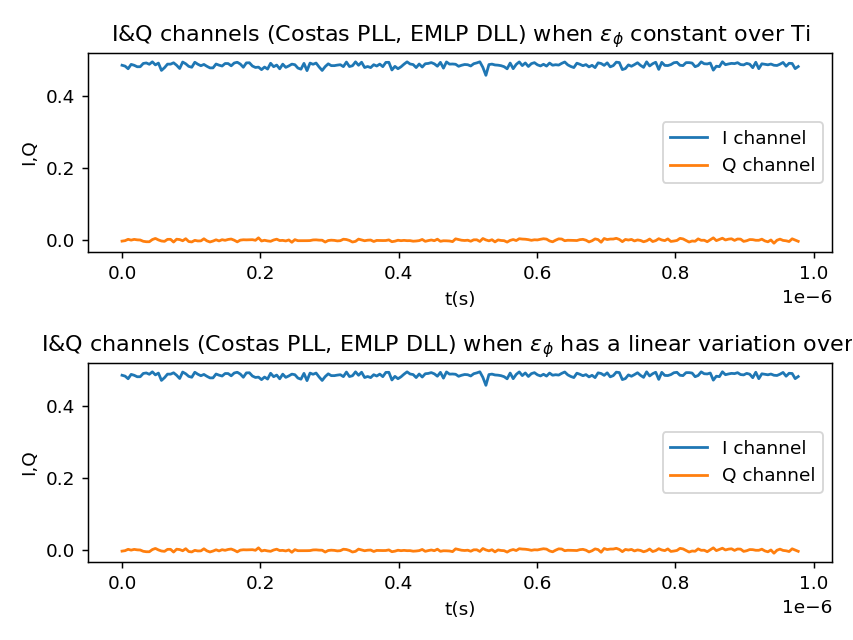

In [22]:
nI, nQ  = np.random.normal(0, N0/(4*Ti)), np.random.normal(0, N0/(4*Ti))
# I&Q channels when $epsilon_phi$ constant over Ti
I_1 = A/2*np.cos(eps_phi["Costas"])*K_cml_cm_interp["EMLP"] + nI
Q_1 = A/2*np.sin(eps_phi["Costas"])*K_cml_cm_interp["EMLP"] + nQ

# I&Q channels when $epsilon_phi$ has a linear variation over Ti
I_2 = A/2*np.cos(eps_phi["Costas"])*K_cml_cm_interp["EMLP"]*np.sinc(eps_fd*Ti) + nI
Q_2 = A/2*np.sin(eps_phi["Costas"])*K_cml_cm_interp["EMLP"]*np.sinc(eps_fd*Ti) + nQ

fig, ax = mpl.subplots(2, 1)
ax[0].plot(t, I_1, label="I channel")
ax[0].plot(t, Q_1, label="Q channel")
ax[0].set_title(r"I&Q channels (Costas PLL, EMLP DLL) when $\epsilon_{\phi}$ constant over Ti")
ax[0].legend(loc="best"), ax[0].set_ylabel("I,Q"), ax[0].set_xlabel("t(s)")
ax[1].plot(t, I_2, label="I channel")
ax[1].plot(t, Q_2, label="Q channel")
ax[1].set_title(r"I&Q channels (Costas PLL, EMLP DLL) when $\epsilon_{\phi}$ has a linear variation over Ti")
ax[1].legend(loc="best"), ax[1].set_ylabel("I,Q"), ax[1].set_xlabel("t(s)")
fig.tight_layout()
mpl.show()
fig.savefig("Results/OutputIQchannels.png")

# 1. Features-based decomposition

# K=3 or 4 for spectral distribution
# Plot FFT for clean and corrupted data

In [23]:
prn_dict["G01"]["distance"]

array([22382132.09915146, 22411037.55491757, 22581734.80247605,
       22757409.63298803, 22937809.79628984, 23122671.42625989,
       23311719.75379781, 23504669.84033585, 23701227.34650223,
       23901089.30661563, 24103944.92199516, 24309476.35445765,
       24517359.52581191, 24727264.90986668, 24938858.32017789,
       25151801.68691336, 25365753.82040429, 25580371.16476132,
       25795308.52671921, 26010219.79568653, 25506316.93836579,
       25306319.03292541, 25108046.08796279, 24911698.92199111,
       24717471.61354041, 24525551.36714529, 24336118.4209265 ,
       24149345.99457854, 23965400.28437591, 23784440.51126843,
       23606618.99872672, 23432081.31529466, 23260966.4510479 ,
       23093407.04256413, 22929529.63592424, 22769455.00024728,
       22613298.46580935, 22461170.30717947, 22313176.14931342,
       22169417.40608235, 22029991.73256123, 21894993.49588322,
       21764514.25926831, 21638643.26510418, 21517467.91197772,
       21401074.22980956, 21289547.32940

In [24]:
from scipy import fft as fft
window = 10
K = np.int32(np.divide(len(prn_dict["G01"]["distance"]), window))
#ts = 1/300
#for n_sat in prn:
#freq = np.fft.fftfreq(prn_dict["G01"]["tx_time"].shape[-1])
Xf = np.fft.fft(prn_dict["G01"]["distance"])

temp = prn_dict["G01"]["distance"] - np.min(prn_dict["G01"]["distance"])
Xf = fft.fft(temp)
#Xf = (2.0/len(Xf)) * np.abs(Xf)
Xf

array([ 3.62591555e+08-0.00000000e+00j, -4.91127139e-09+2.72120815e-09j,
        5.16372684e+07-2.06737561e+08j, -4.65661287e-09-1.05355866e-08j,
       -3.75546913e+07-2.54545766e+07j,  1.74622983e-10+9.64064384e-11j,
       -1.54600273e+07+1.40020589e+07j, -1.32422429e-09+3.14321369e-09j,
        4.63015497e+06+1.16153167e+07j, -1.42608769e-09-1.55705493e-09j,
        7.67955240e+06-2.28781108e+04j, -1.65891834e-09-8.94942787e-10j,
        1.11001757e+06-4.64010967e+06j, -2.82307155e-09-1.57160684e-09j,
       -3.49930745e+06-1.21956567e+06j,  1.68802217e-09-9.49512469e-10j,
       -1.97559643e+06+2.91165236e+06j,  3.17231752e-09+9.08039510e-09j,
        1.62168733e+06+2.65116303e+06j,  9.31322575e-10-1.57160684e-09j,
        2.29658849e+06-3.22714976e+05j,  8.14907253e-10-1.90630089e-09j,
        4.64687225e+04-1.60256610e+06j,  1.22236088e-09+1.48429535e-09j,
       -1.52318783e+06-3.71689863e+04j,  4.65661287e-10+9.09494702e-12j,
       -5.24476484e+05+1.64687742e+06j,  3.31783667

In [210]:
def feature_decomposition(prn, data, window=40):
    #window = 10 # time-window
    features = {}
    for n_sat in prn:
        #if (len(prn_dict[n_sat]["distance"]) == 0): # skip G18, G
        #    continue
        window_counter = 0
        minimum, maximum ,mean, std, skewness, kurt, energy, sde = [],[],[],[],[],[],[],[]
        while(window_counter*window+window < len(data[n_sat]["distance"])):
            minimum.append(np.min(data[n_sat]["distance"][window_counter*window:window_counter*window+window]))
            maximum.append(np.max(data[n_sat]["distance"][window_counter*window:window_counter*window+window]))
            mean.append(np.mean(data[n_sat]["distance"][window_counter*window:window_counter*window+window]))
            skewness.append(skew(data[n_sat]["distance"][window_counter*window:window_counter*window+window],nan_policy="omit"))
            kurt.append(kurtosis(data[n_sat]["distance"][window_counter*window:window_counter*window+window],nan_policy="omit"))
            energy.append((1/window)*np.sum(data[n_sat]["distance"][window_counter*window:window_counter*window+window]**2))
            window_counter += 1

        minimum.append(np.min(data[n_sat]["distance"][window_counter*window:len(data[n_sat]["distance"])]))
        maximum.append(np.max(data[n_sat]["distance"][window_counter*window:len(data[n_sat]["distance"])]))
        mean.append(np.mean(data[n_sat]["distance"][window_counter*window:len(data[n_sat]["distance"])]))
        skewness.append(skew(data[n_sat]["distance"][window_counter*window:len(data[n_sat]["distance"])]))
        kurt.append(kurtosis(data[n_sat]["distance"][window_counter*window:len(data[n_sat]["distance"])]))
        energy.append((1/(len(data[n_sat]["distance"])-window_counter*window))
        *np.sum(data[n_sat]["distance"][window_counter*window:len(data[n_sat]["distance"])]))
    
        features[n_sat] = {"min": minimum, "max": maximum, "mean": mean, "skew": skewness, "kurt": kurt, "energy": energy}
    
    return features

## 1.a Run the feature decomposition separately on both clean and corrupted pseudoranges

## Build the dataframe of features

In [211]:
# Apply feature-decomposition of the clean data
features     = feature_decomposition(prn, prn_dict)
# Apply feature-decomposition of the corrupted data
corrupted_features = feature_decomposition(prn, corrupted_prn_dict)

features_df           = [] # clean pseudoranges feature-decomposed dataframe
corrupted_features_df = [] # corrupted pseudoranges feature-decomposed dataframe

for n_sat in prn: 
    # build clean dataframe from the clean dictionary for each visible PRN
    features_temp = pd.DataFrame.from_dict(features[n_sat])
    # insert the PRN column in the clean dataframe for each visible PRN
    features_temp.insert(0, 'PRN', n_sat)
    # concatenate clean dataframes
    features_df.append(features_temp)
    
    # build corrupted dataframe from the corrupted dictionary for each visible PRN
    corrupted_features_temp = pd.DataFrame.from_dict(corrupted_features[n_sat])
    # insert the PRN column in the corrupted dataframe for each visible PRN
    corrupted_features_temp.insert(0, 'PRN', n_sat)
    # concatenate corrupted dataframes
    corrupted_features_df.append(corrupted_features_temp)

# build the clean and corrputed dataframes separately by concatenating the dataframe for each PRN
features_df     = pd.concat(features_df, ignore_index=True)
corrupted_features_df = pd.concat(corrupted_features_df, ignore_index=True)

features_df

PRN           min           max          mean      skew      kurt  \
0    G01  2.216942e+07  2.601022e+07  2.390179e+07  0.165555 -1.146539   
1    G01  2.021143e+07  2.202999e+07  2.071285e+07  1.079336  0.116381   
2    G01  2.100565e+07  2.601022e+07  2.357904e+07 -0.198786 -1.205512   
3    G01  2.021143e+07  2.360662e+07  2.128902e+07  0.713953 -0.804000   
4    G01  2.030143e+07  2.221759e+07  2.106706e+07  0.440485 -1.058131   
..   ...           ...           ...           ...       ...       ...   
156  G31  2.085206e+07  2.414147e+07  2.177928e+07  1.014033 -0.254193   
157  G31  2.376595e+07  2.588195e+07  2.442111e+07  0.763542 -0.563092   
158  G31  2.098326e+07  2.565803e+07  2.336967e+07 -0.126109 -1.446075   
159  G31  2.085206e+07  2.569578e+07  2.253366e+07  0.561992 -1.067367   
160  G31  2.376595e+07  2.588195e+07  2.434516e+07  0.918645 -0.179115   

           energy  
0    5.724899e+14  
1    4.292813e+14  
2    5.581319e+14  
3    4.543450e+14  
4    2.106706e+07  
..            ...  
156  4.752966e+14  
157  5.967542e+14  
158  5.484629e+14  
159  5.102338e+14  
160  2.434516e+07  

[161 rows x 7 columns]

## Minmax and Mean normalize the feature space and compute PCA

In [212]:
def plot_weight_matrix(PCA, data, text):
    # component loadings or weights (correlation coefficient between original variables and the component) 
    # component loadings represents the elements of the eigenvector
    # the squared loadings within the PCs always sums to 1
    loadings = PCA.components_
    num_pc = PCA.n_features_
    pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
    loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    loadings_df['feature'] = data.columns.values
    loadings_df = loadings_df.set_index('feature')

    # positive and negative values in component loadings reflects the positive and negative 

    # get correlation matrix plot for loadings
    fig, ax = mpl.subplots() 
    ax = sb.heatmap(loadings_df, annot=True, cmap='Spectral')
    ax.set_title(text)
    mpl.tight_layout()
    return fig, loadings_df

In [213]:
def loading_plot(df, ax):
    # Define the x, y, z variables
    x_loading = np.array(minmax_weight_df["PC1"])
    y_loading = np.array(minmax_weight_df["PC2"])
    z_loading = np.array(minmax_weight_df["PC3"])

    # Initialize the 3D graph
    #fig = mpl.figure()
    #ax = fig.add_subplot(111, projection='3d')
    # Plot the loadings
    feature_names = minmax_weight_df.index.values
    for i, varnames in enumerate(feature_names):
        ax.scatter(x_loading[i], y_loading[i], z_loading[i], s=200)
        ax.text(
            x_loading[i] + 0.1, 
            y_loading[i] + 0.1, 
            z_loading[i] + 0.1, 
            varnames)

    # Plot the arrows
    x_arr = np.zeros(len(x_loading))
    y_arr = z_arr = x_arr
    ax.quiver(x_arr, y_arr, z_arr, x_loading, y_loading, z_loading, color='k')
    return x_loading, y_loading, z_loading

/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


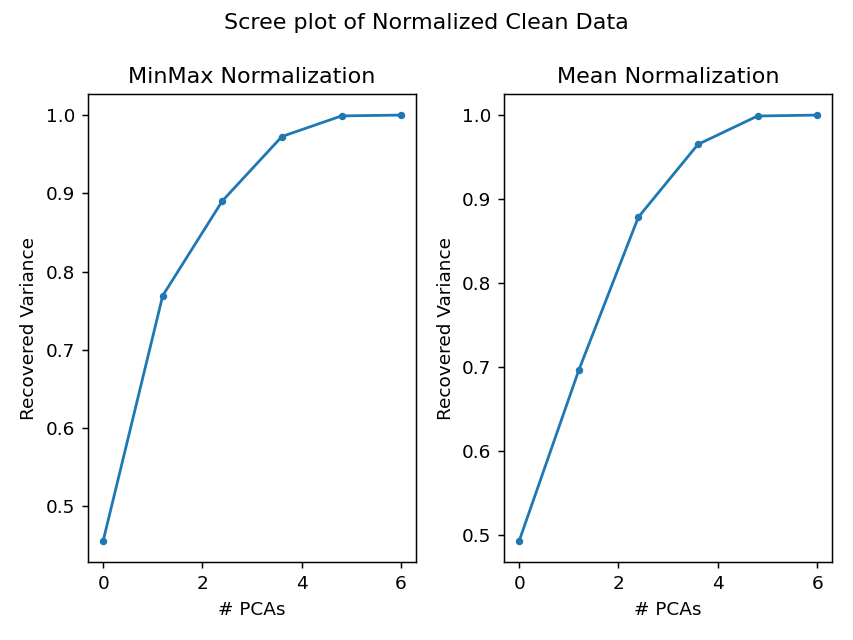

<IPython.core.display.Javascript object>


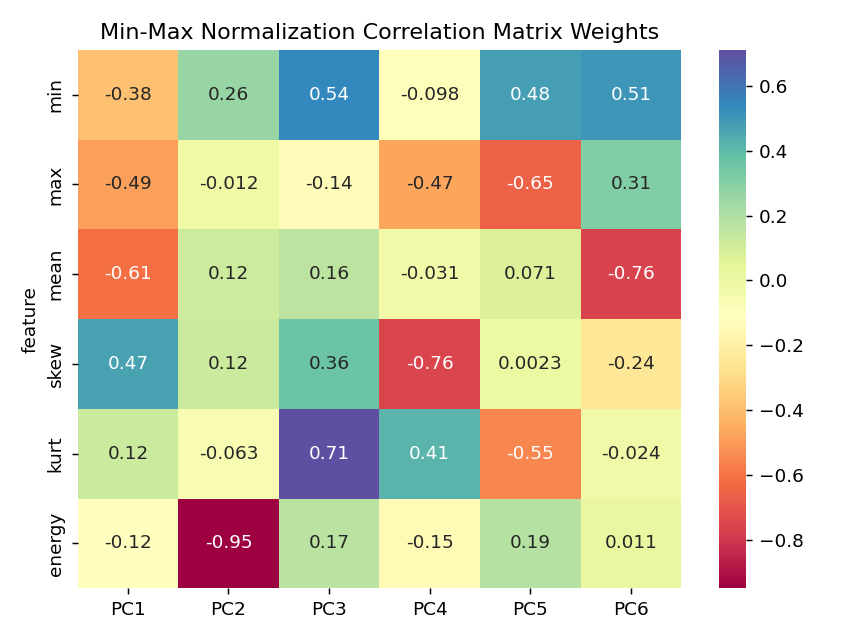

<IPython.core.display.Javascript object>


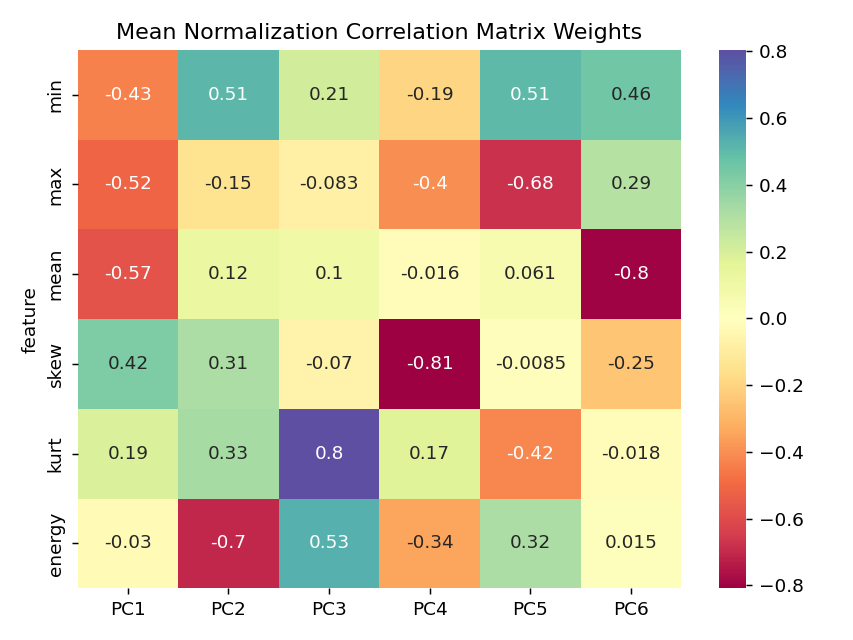

In [214]:
X             = features_df.loc[:,features_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
X_minmax_norm = ((X-X.min())/(X.max()-X.min())) # normalized X
# mean normalization
X_mean_norm   = (X-X.mean())/X.std()

# Apply PCA with all components and TSNE on clean data
PCA_minmax  = PCA().fit(X_minmax_norm)
PCA_mean    = PCA().fit(X_mean_norm)
TSNE_minmax = TSNE().fit(X_minmax_norm)
TSNE_mean   = TSNE().fit(X_mean_norm)

# Recovered variance
recovered_var_minmax = np.cumsum(PCA_minmax.explained_variance_ratio_)
recovered_var_mean   = np.cumsum(PCA_mean.explained_variance_ratio_)
fig, ax = mpl.subplots(1,2)
ax[0].plot(np.linspace(0, len(recovered_var_minmax), len(recovered_var_minmax)), recovered_var_minmax, '.-')
ax[0].set_title("MinMax Normalization"), ax[0].set_ylabel("Recovered Variance"), ax[0].set_xlabel("# PCAs")
ax[1].plot(np.linspace(0, len(recovered_var_mean),   len(recovered_var_mean)), recovered_var_mean, '.-')
ax[1].set_title("Mean Normalization"),   ax[1].set_ylabel("Recovered Variance"), ax[1].set_xlabel("# PCAs")
fig.suptitle("Scree plot of Normalized Clean Data")
mpl.tight_layout()

fig1, minmax_weight_df = plot_weight_matrix(PCA_minmax, X_minmax_norm, "Min-Max Normalization Correlation Matrix Weights")
fig2, mean_weight_df = plot_weight_matrix(PCA_mean, X_mean_norm, "Mean Normalization Correlation Matrix Weights")

## For both normalizations the first 3 PCAs recover more than 95% of the variance

/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  w

<IPython.core.display.Javascript object>


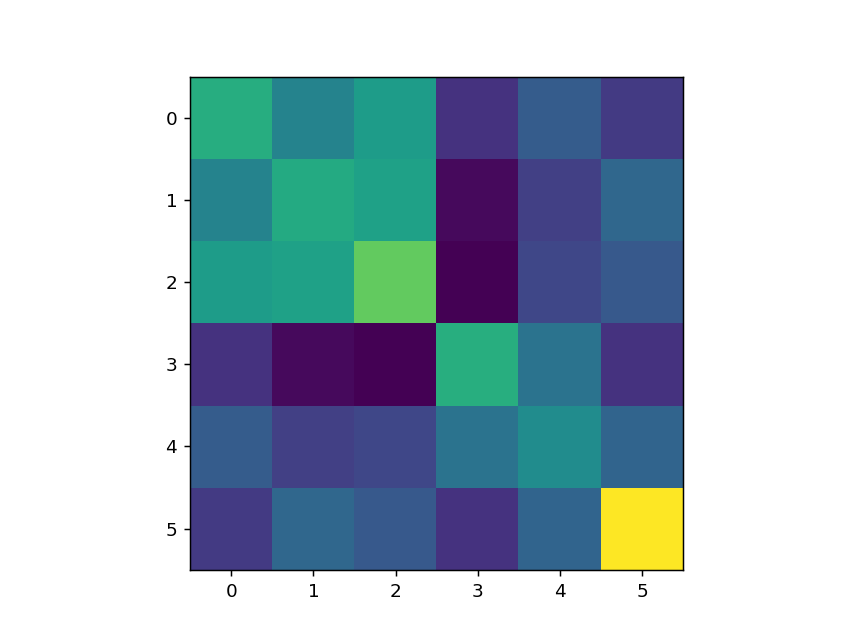

Explained Variances for both minmax and mean methods


(0.8902554553128007, 0.8783917586899576)

In [216]:
# Apply PCA with all components and TSNE on clean data
PCA_minmax  = PCA(n_components=3).fit(X_minmax_norm)
PCA_mean    = PCA(n_components=3).fit(X_mean_norm)
TSNE_minmax = TSNE(n_components=3).fit(X_minmax_norm)
TSNE_mean   = TSNE(n_components=3).fit(X_mean_norm)

features_PCA_minmax  = PCA_minmax.transform(X_minmax_norm)
features_PCA_mean    = PCA_mean.transform(X_mean_norm)
features_TSNE_minmax = TSNE(n_components=3).fit_transform(X_minmax_norm)
features_TSNE_mean   = TSNE(n_components=3).fit_transform(X_mean_norm)

var = PCA_minmax.get_covariance()
fig, ax = mpl.subplots()
ax.imshow(var)
mpl.show()

print("Explained Variances for both minmax and mean methods")
np.sum(PCA_minmax.explained_variance_ratio_), np.sum(PCA_mean.explained_variance_ratio_)

<IPython.core.display.Javascript object>


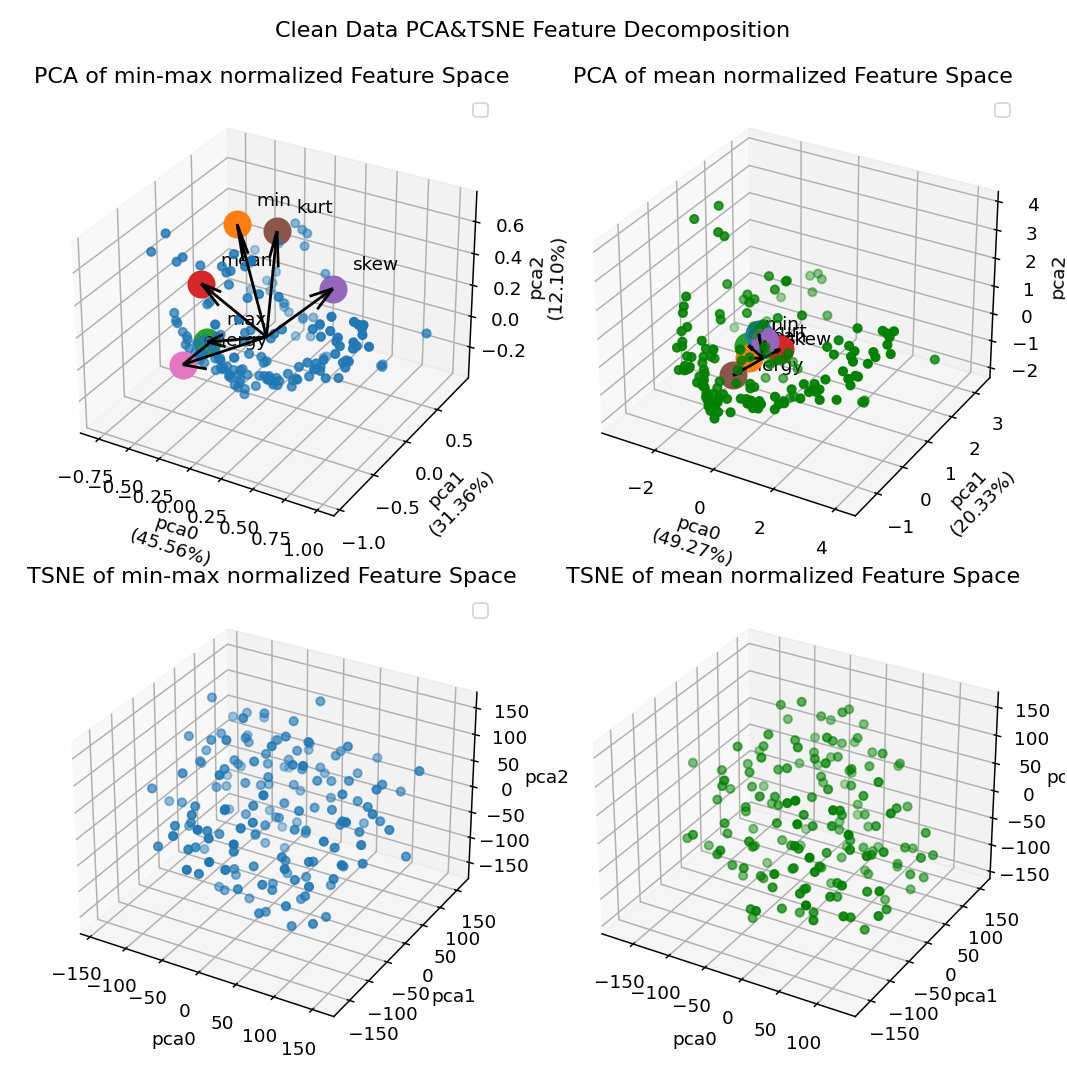

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [217]:
# Build Dataframes out of PCA and TSNE features
df_PCA_minmax  = pd.DataFrame({"PRN":list(features_df["PRN"])})
df_PCA_mean    = pd.DataFrame({"PRN":list(features_df["PRN"])})
df_TSNE_minmax = pd.DataFrame({"PRN":list(features_df["PRN"])})
df_TSNE_mean   = pd.DataFrame({"PRN":list(features_df["PRN"])})
PCA_names      = list(PCA_minmax.get_feature_names_out())

# PCA step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
# Parallel Iteration
for entry_minmax,entry_mean in zip(features_PCA_minmax, features_PCA_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean   = np.append(data_x_mean,entry_mean[0])
    data_y_mean   = np.append(data_y_mean,entry_mean[1])
    data_z_mean   = np.append(data_z_mean,entry_mean[2])

df_PCA_minmax[PCA_names[0]], df_PCA_minmax[PCA_names[1]], df_PCA_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_PCA_mean[PCA_names[0]],   df_PCA_mean[PCA_names[1]],   df_PCA_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean
PCA_var_minmax = PCA_minmax.explained_variance_ratio_ * 100
PCA_var_mean   = PCA_mean.explained_variance_ratio_ * 100

# TSNE step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
for entry_minmax,entry_mean in zip(features_TSNE_minmax, features_TSNE_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean   = np.append(data_x_mean,entry_mean[0])
    data_y_mean   = np.append(data_y_mean,entry_mean[1])
    data_z_mean   = np.append(data_z_mean,entry_mean[2])

df_TSNE_minmax[PCA_names[0]], df_TSNE_minmax[PCA_names[1]], df_TSNE_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_TSNE_mean[PCA_names[0]],   df_TSNE_mean[PCA_names[1]],   df_TSNE_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean

fig = mpl.figure(figsize=(8,8))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(df_PCA_minmax[PCA_names[0]], df_PCA_minmax[PCA_names[1]], df_PCA_minmax[PCA_names[2]]);
ax.set_xlabel(f'{PCA_names[0]}\n({PCA_var_minmax[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCA_var_minmax[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCA_var_minmax[2]:.2f}%)')
ax.set_title('PCA of min-max normalized Feature Space')
ax.legend(loc="best")
x_minmax_loading, y_minmax_loading, z_minmax_loading = loading_plot(minmax_weight_df, ax)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter3D(df_PCA_mean[PCA_names[0]], df_PCA_mean[PCA_names[1]], df_PCA_mean[PCA_names[2]], c='g');
ax.set_xlabel(f'{PCA_names[0]}\n({PCA_var_mean[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCA_var_mean[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCA_var_mean[2]:.2f}%)')
ax.set_title('PCA of mean normalized Feature Space')
ax.legend(loc="best")
x_mean_loading, y_mean_loading, z_mean_loading = loading_plot(mean_weight_df, ax)


ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter3D(df_TSNE_minmax[PCA_names[0]], df_TSNE_minmax[PCA_names[1]], df_TSNE_minmax[PCA_names[2]]);
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2]), 
ax.set_title(f"TSNE of min-max normalized Feature Space")
ax.legend(loc="best")

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D(df_TSNE_mean[PCA_names[0]], df_TSNE_mean[PCA_names[1]], df_TSNE_mean[PCA_names[2]], c='g');
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2])
ax.set_title(f"TSNE of mean normalized Feature Space")
fig.suptitle("Clean Data PCA&TSNE Feature Decomposition")
mpl.tight_layout()
mpl.show()

## Corrupted data PCA decomposition

/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


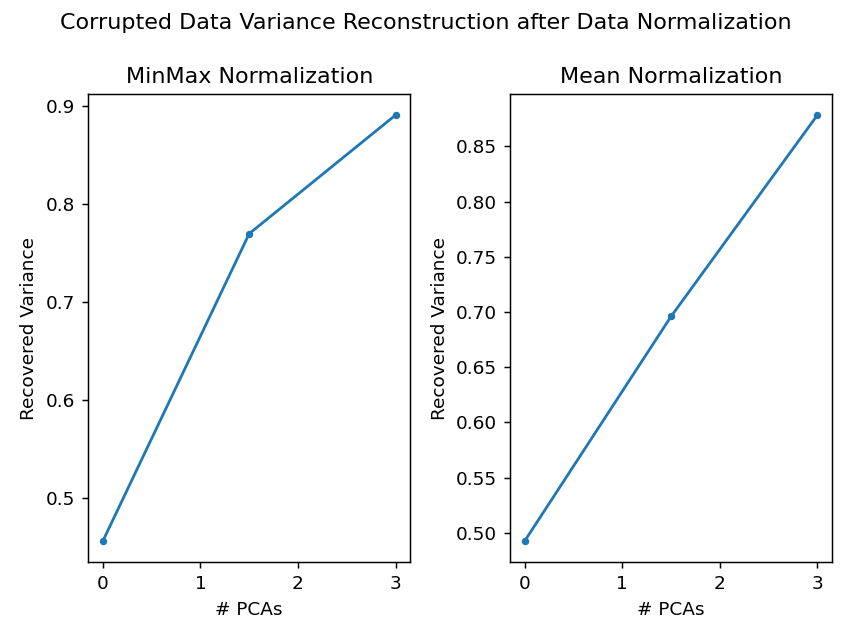

<IPython.core.display.Javascript object>


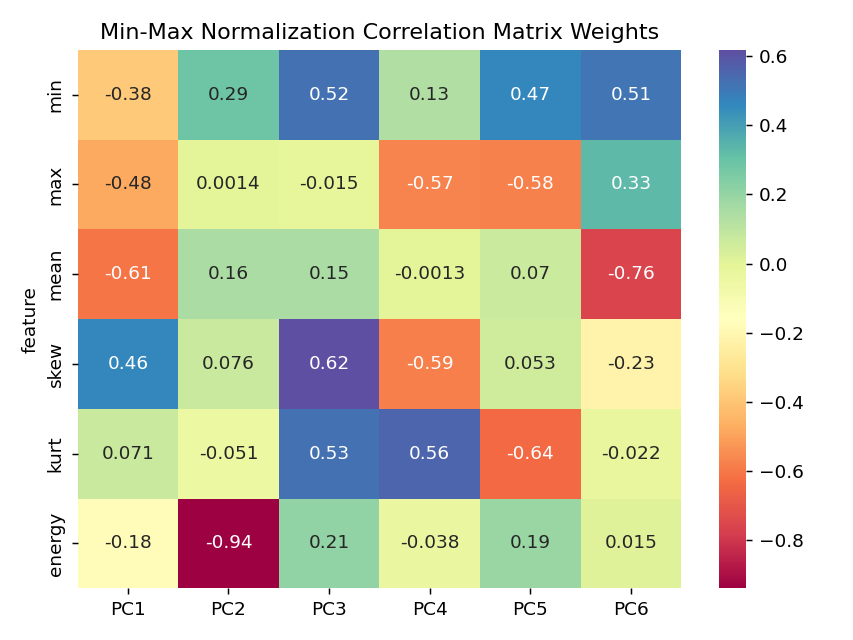

<IPython.core.display.Javascript object>


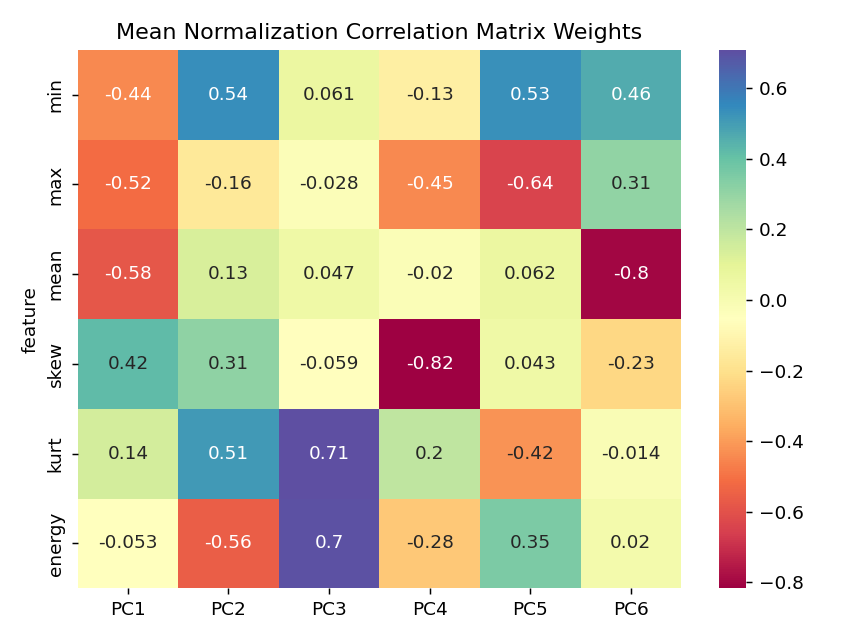

/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  w

Explained Variances for both normalization methods


<IPython.core.display.Javascript object>


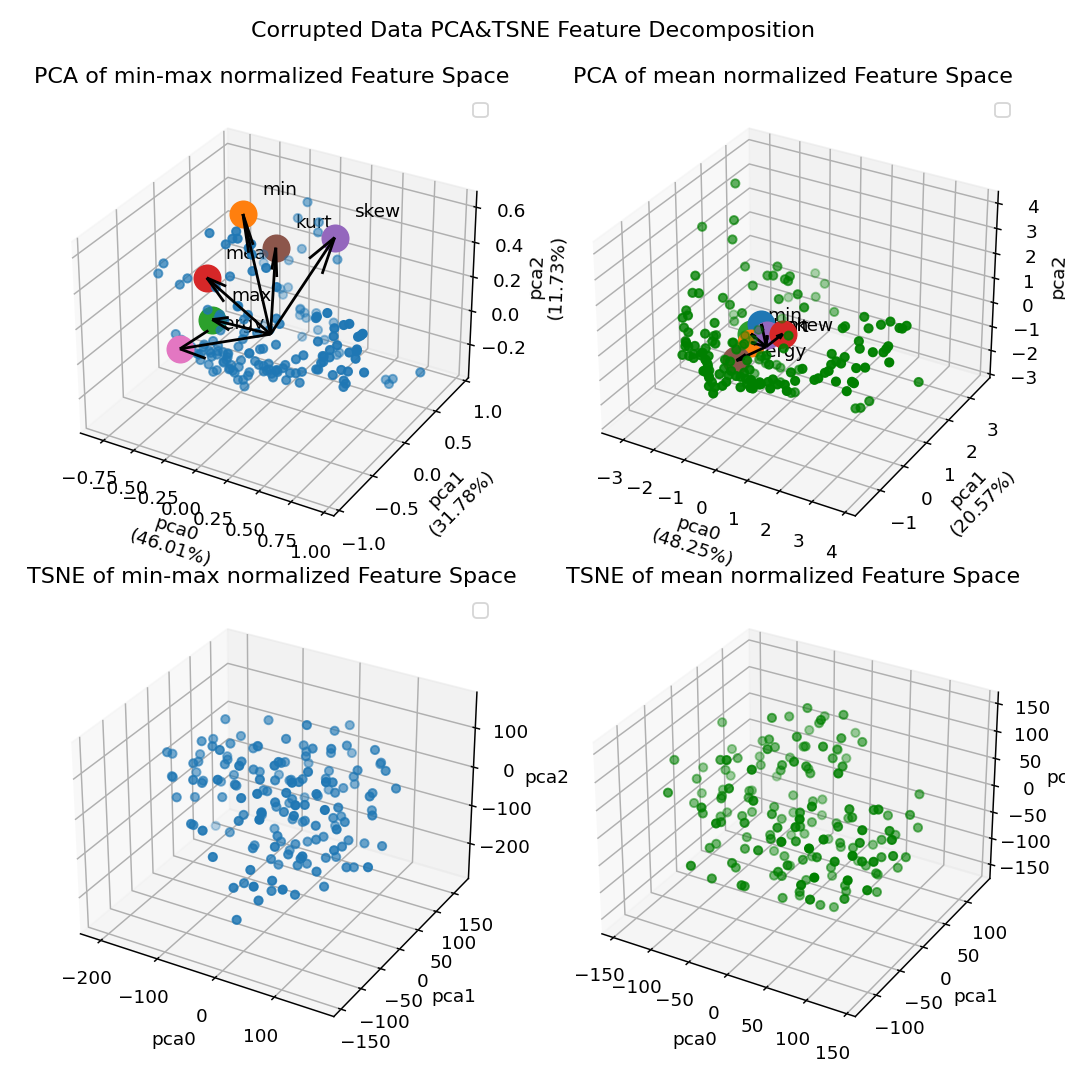

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [218]:
Xc             = corrupted_features_df.loc[:,corrupted_features_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
Xc_minmax_norm = ((Xc-Xc.min())/(Xc.max()-Xc.min())) # normalized X
# mean normalization
Xc_mean_norm   = (Xc-Xc.mean())/Xc.std()

# Apply PCA with all components and TSNE on corrupted data
PCAc_minmax  = PCA().fit(Xc_minmax_norm)
PCAc_mean    = PCA().fit(Xc_mean_norm)
TSNEc_minmax = TSNE().fit(Xc_minmax_norm)
TSNEc_mean   = TSNE().fit(Xc_mean_norm)

# Recovered variance
recovered_var_minmax = np.cumsum(PCA_minmax.explained_variance_ratio_)
recovered_var_mean   = np.cumsum(PCA_mean.explained_variance_ratio_)
fig, ax = mpl.subplots(1,2)
ax[0].plot(np.linspace(0, len(recovered_var_minmax), len(recovered_var_minmax)), recovered_var_minmax, '.-')
ax[0].set_title("MinMax Normalization"), ax[0].set_ylabel("Recovered Variance"), ax[0].set_xlabel("# PCAs")
ax[1].plot(np.linspace(0, len(recovered_var_mean),   len(recovered_var_mean)), recovered_var_mean, '.-')
ax[1].set_title("Mean Normalization"),   ax[1].set_ylabel("Recovered Variance"), ax[1].set_xlabel("# PCAs")
fig.suptitle("Corrupted Data Variance Reconstruction after Data Normalization")
mpl.tight_layout()

fig1, minmax_weight_df = plot_weight_matrix(PCAc_minmax, Xc_minmax_norm, "Min-Max Normalization Correlation Matrix Weights")
fig2, mean_weight_df = plot_weight_matrix(PCAc_mean, Xc_mean_norm, "Mean Normalization Correlation Matrix Weights")

# Apply PCA and TSNE on clean data
PCAc_minmax  = PCA(n_components=3).fit(Xc_minmax_norm)
PCAc_mean    = PCA(n_components=3).fit(Xc_mean_norm)
TSNEc_minmax = TSNE(n_components=3).fit(Xc_minmax_norm)
TSNEc_mean   = TSNE(n_components=3).fit(Xc_mean_norm)

features_PCAc_minmax  = PCAc_minmax.transform(Xc_minmax_norm)
features_PCAc_mean    = PCAc_mean.transform(Xc_mean_norm)
features_TSNEc_minmax = TSNE(n_components=3).fit_transform(Xc_minmax_norm)
features_TSNEc_mean   = TSNE(n_components=3).fit_transform(Xc_mean_norm)

print("Explained Variances for both normalization methods")
np.sum(PCAc_minmax.explained_variance_ratio_), np.sum(PCAc_mean.explained_variance_ratio_)

# Build Dataframes out of PCA and TSNE corrupted features
df_PCAc_minmax  = pd.DataFrame({"PRN":list(corrupted_features_df["PRN"])})
df_PCAc_mean    = pd.DataFrame({"PRN":list(corrupted_features_df["PRN"])})
df_TSNEc_minmax = pd.DataFrame({"PRN":list(corrupted_features_df["PRN"])})
df_TSNEc_mean   = pd.DataFrame({"PRN":list(corrupted_features_df["PRN"])})
PCA_names       = list(PCA_minmax.get_feature_names_out())

# PCA step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
# Parallel Iteration
for entry_minmax,entry_mean in zip(features_PCAc_minmax,features_PCAc_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean = np.append(data_x_mean,entry_mean[0])
    data_y_mean = np.append(data_y_mean,entry_mean[1])
    data_z_mean = np.append(data_z_mean,entry_mean[2])

df_PCAc_minmax[PCA_names[0]], df_PCAc_minmax[PCA_names[1]], df_PCAc_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_PCAc_mean[PCA_names[0]],   df_PCAc_mean[PCA_names[1]],   df_PCAc_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean
PCAc_var_minmax = PCAc_minmax.explained_variance_ratio_ * 100
PCAc_var_mean   = PCAc_mean.explained_variance_ratio_ * 100

# TSNE step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
# Parallel Iteration
for entry_minmax,entry_mean in zip(features_TSNEc_minmax,features_TSNEc_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean = np.append(data_x_mean,entry_mean[0])
    data_y_mean = np.append(data_y_mean,entry_mean[1])
    data_z_mean = np.append(data_z_mean,entry_mean[2])

df_TSNEc_minmax[PCA_names[0]], df_TSNEc_minmax[PCA_names[1]], df_TSNEc_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_TSNEc_mean[PCA_names[0]],   df_TSNEc_mean[PCA_names[1]],   df_TSNEc_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean


fig = mpl.figure(figsize=(8,8))
ax = fig.add_subplot(2, 2, 1, projection='3d')

ax.scatter3D(df_PCAc_minmax[PCA_names[0]], df_PCAc_minmax[PCA_names[1]], df_PCAc_minmax[PCA_names[2]]);
ax.set_xlabel(f'{PCA_names[0]}\n({PCAc_var_minmax[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCAc_var_minmax[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCAc_var_minmax[2]:.2f}%)')
ax.set_title('PCA of min-max normalized Feature Space')
ax.legend(loc="best")
x_minmax_loading, y_minmax_loading, z_minmax_loading = loading_plot(minmax_weight_df, ax)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter3D(df_PCAc_mean[PCA_names[0]], df_PCAc_mean[PCA_names[1]], df_PCAc_mean[PCA_names[2]], c='g');
ax.set_xlabel(f'{PCA_names[0]}\n({PCAc_var_mean[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCAc_var_mean[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCAc_var_mean[2]:.2f}%)')
ax.set_title('PCA of mean normalized Feature Space')
ax.legend(loc="best")
x_mean_loading, y_mean_loading, z_mean_loading = loading_plot(mean_weight_df, ax)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter3D(df_TSNEc_minmax[PCA_names[0]], df_TSNEc_minmax[PCA_names[1]], df_TSNEc_minmax[PCA_names[2]]);
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2]), 
ax.set_title(f"TSNE of min-max normalized Feature Space")
ax.legend(loc="best")

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D(df_TSNEc_mean[PCA_names[0]], df_TSNEc_mean[PCA_names[1]], df_TSNEc_mean[PCA_names[2]], c='g');
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2])
ax.set_title(f"TSNE of mean normalized Feature Space")
fig.suptitle("Corrupted Data PCA&TSNE Feature Decomposition")
mpl.tight_layout()
mpl.show()

## Way to fix the number of components. Plot the variance recovery

## 1. Combine the clean and corrupted dataframes and run PCA
## 2. Run PCA on clean data and project corrupted data using the PCAs of clean data (more complex)

In [219]:
# Append Corrupted features after clean features
mixed_features_df = []
for n_sat in prn: 
    frames = [features_df.loc[features_df["PRN"]==n_sat],
              corrupted_features_df.loc[corrupted_features_df["PRN"]==n_sat]]
    mixed_features_temp = pd.concat(frames)
    mixed_features_df.append(mixed_features_temp)
    
mixed_features_df = pd.concat(mixed_features_df,ignore_index=True)
mixed_features_df

PRN           min           max          mean      skew      kurt  \
0    G01  2.216942e+07  2.601022e+07  2.390179e+07  0.165555 -1.146539   
1    G01  2.021143e+07  2.202999e+07  2.071285e+07  1.079336  0.116381   
2    G01  2.100565e+07  2.601022e+07  2.357904e+07 -0.198786 -1.205512   
3    G01  2.021143e+07  2.360662e+07  2.128902e+07  0.713953 -0.804000   
4    G01  2.030143e+07  2.221759e+07  2.106706e+07  0.440485 -1.058131   
..   ...           ...           ...           ...       ...       ...   
317  G31  2.083180e+07  2.403398e+07  2.172160e+07  1.048183 -0.133173   
318  G31  2.375009e+07  2.587450e+07  2.440640e+07  0.796814 -0.550678   
319  G31  2.105102e+07  2.561818e+07  2.344661e+07 -0.182735 -1.395910   
320  G31  2.079565e+07  2.549508e+07  2.242218e+07  0.623783 -0.975911   
321  G31  2.373726e+07  2.579386e+07  2.442760e+07  0.656100 -0.869920   

           energy  
0    5.724899e+14  
1    4.292813e+14  
2    5.581319e+14  
3    4.543450e+14  
4    2.106706e+07  
..            ...  
317  4.726534e+14  
318  5.960372e+14  
319  5.519429e+14  
320  5.050136e+14  
321  2.442760e+07  

[322 rows x 7 columns]

/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


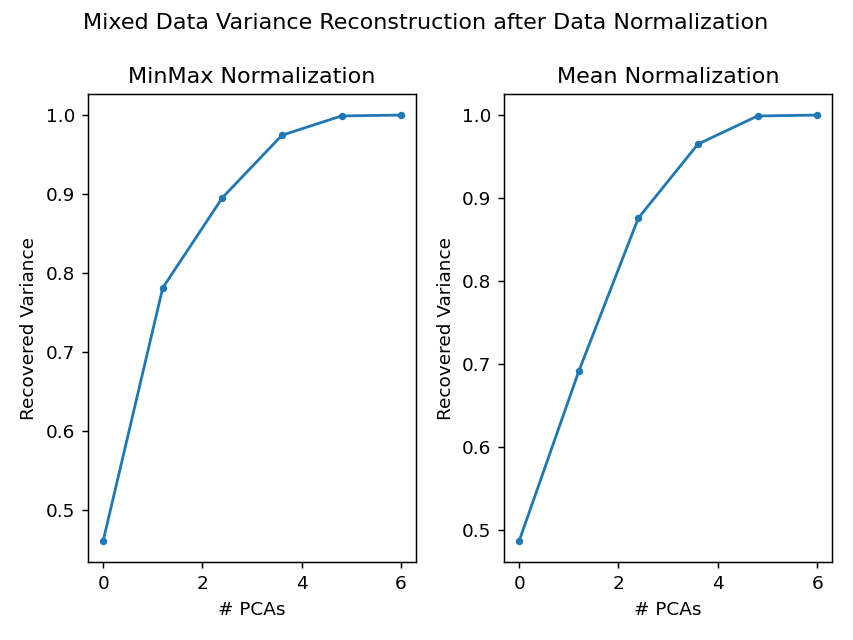

<IPython.core.display.Javascript object>


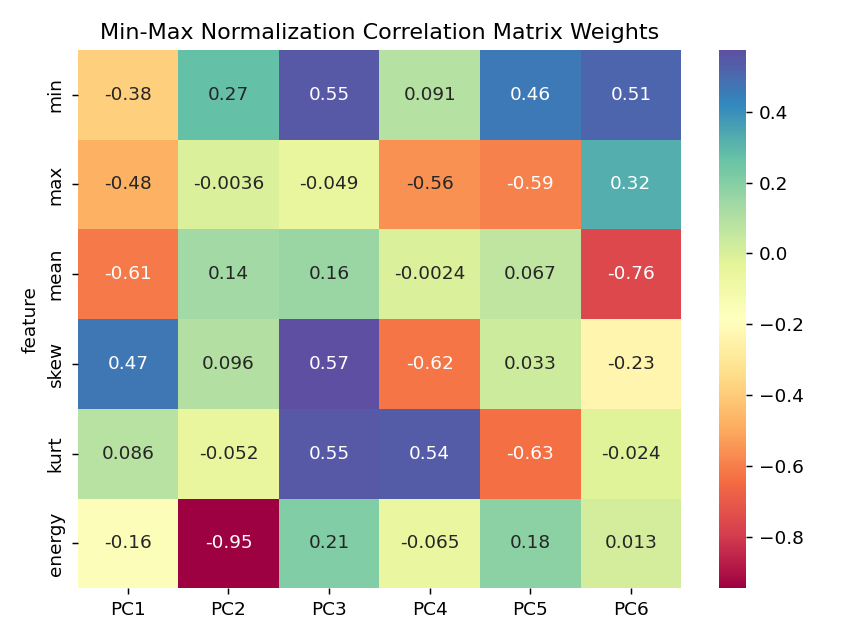

<IPython.core.display.Javascript object>


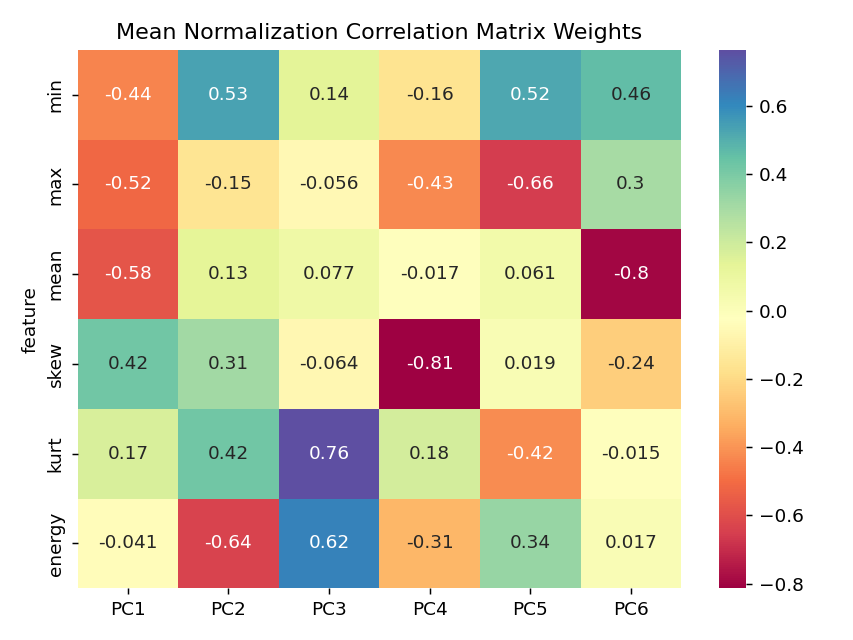

/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vlad/ENAC/Pseudorange/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  w

Explained Variances for both normalization methods


<IPython.core.display.Javascript object>


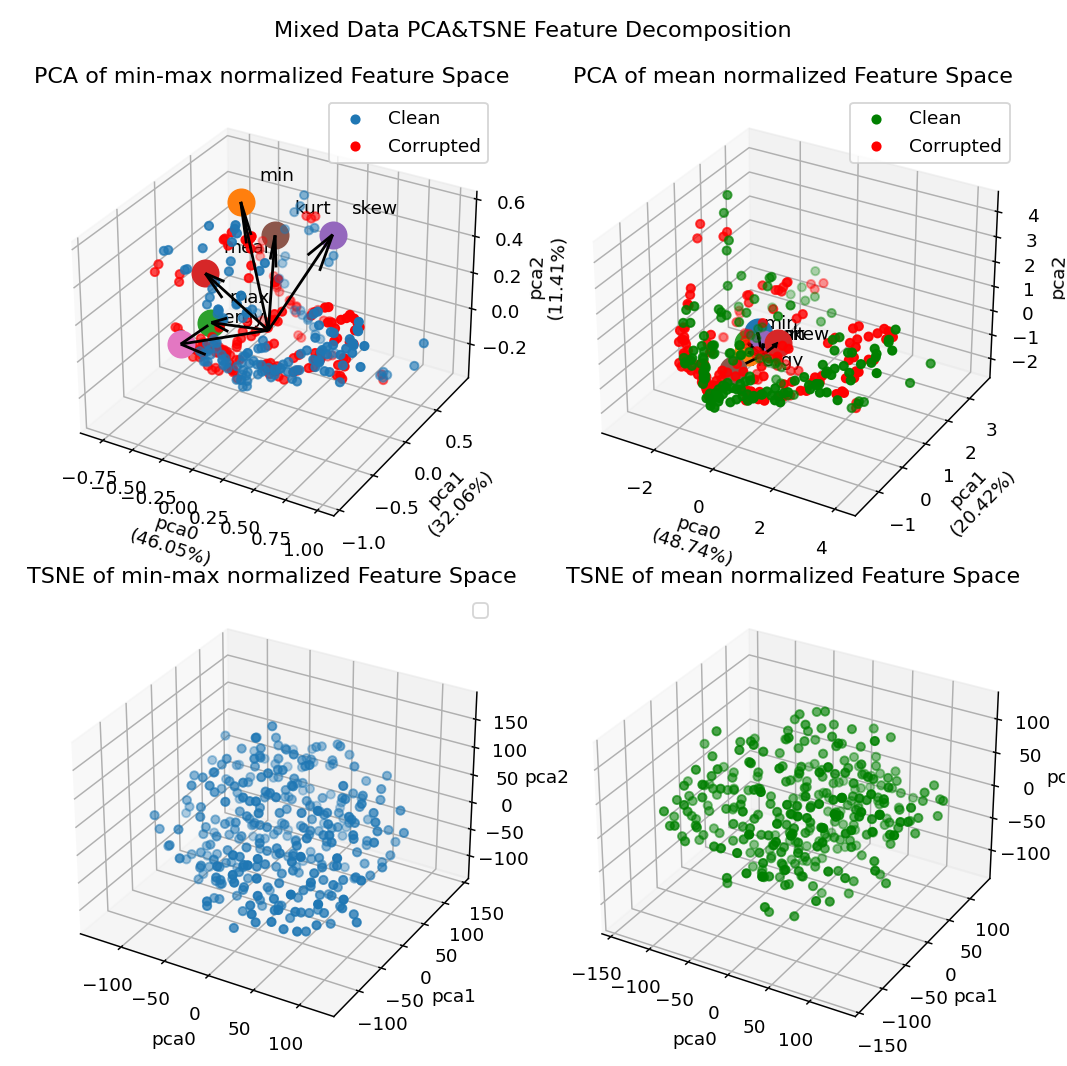

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [220]:
Xm             = mixed_features_df.loc[:,mixed_features_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
Xm_minmax_norm = ((Xm-Xm.min())/(Xm.max()-Xm.min())) # normalized X
# mean normalization
Xm_mean_norm   = (Xm-Xm.mean())/Xm.std()

# Apply PCA with all components and TSNE on mixed data
PCAm_minmax  = PCA().fit(Xm_minmax_norm)
PCAm_mean    = PCA().fit(Xm_mean_norm)
TSNEm_minmax = TSNE().fit(Xm_minmax_norm)
TSNEm_mean   = TSNE().fit(Xm_mean_norm)

# Recovered variance
recovered_var_minmax = np.cumsum(PCAm_minmax.explained_variance_ratio_)
recovered_var_mean   = np.cumsum(PCAm_mean.explained_variance_ratio_)
fig, ax = mpl.subplots(1,2)
ax[0].plot(np.linspace(0, len(recovered_var_minmax), len(recovered_var_minmax)), recovered_var_minmax, '.-')
ax[0].set_title("MinMax Normalization"), ax[0].set_ylabel("Recovered Variance"), ax[0].set_xlabel("# PCAs")
ax[1].plot(np.linspace(0, len(recovered_var_mean),   len(recovered_var_mean)), recovered_var_mean, '.-')
ax[1].set_title("Mean Normalization"),   ax[1].set_ylabel("Recovered Variance"), ax[1].set_xlabel("# PCAs")
fig.suptitle("Mixed Data Variance Reconstruction after Data Normalization")
mpl.tight_layout()

fig1, minmax_weight_df = plot_weight_matrix(PCAm_minmax, Xm_minmax_norm, "Min-Max Normalization Correlation Matrix Weights")
fig2, mean_weight_df = plot_weight_matrix(PCAm_mean, Xm_mean_norm, "Mean Normalization Correlation Matrix Weights")

# Apply PCA and TSNE on the optimal number of components
PCAm_minmax  = PCA(n_components=3).fit(Xm_minmax_norm)
PCAm_mean    = PCA(n_components=3).fit(Xm_mean_norm)
TSNEm_minmax = TSNE(n_components=3).fit(Xm_minmax_norm)
TSNEm_mean   = TSNE(n_components=3).fit(Xm_mean_norm)

features_PCAm_minmax  = PCAm_minmax.transform(Xm_minmax_norm)
features_PCAm_mean    = PCAm_mean.transform(Xm_mean_norm)
features_TSNEm_minmax = TSNE(n_components=3).fit_transform(Xm_minmax_norm)
features_TSNEm_mean   = TSNE(n_components=3).fit_transform(Xm_mean_norm)

print("Explained Variances for both normalization methods")
np.sum(PCAm_minmax.explained_variance_ratio_), np.sum(PCAm_mean.explained_variance_ratio_)

df_PCAm_minmax  = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
df_PCAm_mean    = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
df_TSNEm_minmax = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
df_TSNEm_mean   = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
PCA_names       = list(PCAm_minmax.get_feature_names_out())

# PCA step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
for entry_minmax,entry_mean in zip(features_PCAm_minmax, features_PCAm_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean = np.append(data_x_mean,entry_mean[0])
    data_y_mean = np.append(data_y_mean,entry_mean[1])
    data_z_mean = np.append(data_z_mean,entry_mean[2])

df_PCAm_minmax[PCA_names[0]], df_PCAm_minmax[PCA_names[1]], df_PCAm_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_PCAm_mean[PCA_names[0]],   df_PCAm_mean[PCA_names[1]],   df_PCAm_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean
PCAm_var_minmax = PCAm_minmax.explained_variance_ratio_ * 100
PCAm_var_mean   = PCAm_mean.explained_variance_ratio_ * 100

# TSNE step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
for entry_minmax,entry_mean in zip(features_TSNEm_minmax, features_TSNEm_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean = np.append(data_x_mean,entry_mean[0])
    data_y_mean = np.append(data_y_mean,entry_mean[1])
    data_z_mean = np.append(data_z_mean,entry_mean[2])

df_TSNEm_minmax[PCA_names[0]], df_TSNEm_minmax[PCA_names[1]], df_TSNEm_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_TSNEm_mean[PCA_names[0]],   df_TSNEm_mean[PCA_names[1]],   df_TSNEm_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean


fig = mpl.figure(figsize=(8,8))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(df_PCAm_minmax[PCA_names[0]][:len(features_df)], df_PCAm_minmax[PCA_names[1]][:len(features_df)], df_PCAm_minmax[PCA_names[2]][:len(features_df)],label="Clean")
ax.scatter3D(df_PCAm_minmax[PCA_names[0]][len(features_df):-1], df_PCAm_minmax[PCA_names[1]][len(features_df):-1], df_PCAm_minmax[PCA_names[2]][len(features_df):-1],label="Corrupted",c='r')
ax.set_xlabel(f'{PCA_names[0]}\n({PCAm_var_minmax[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCAm_var_minmax[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCAm_var_minmax[2]:.2f}%)')
ax.set_title('PCA of min-max normalized Feature Space')
ax.legend(loc="best")
x_minmax_loading, y_minmax_loading, z_minmax_loading = loading_plot(minmax_weight_df, ax)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter3D(df_PCAm_mean[PCA_names[0]][:len(features_df)], df_PCAm_mean[PCA_names[1]][:len(features_df)], df_PCAm_mean[PCA_names[2]][:len(features_df)], label= "Clean", c='g');
ax.scatter3D(df_PCAm_mean[PCA_names[0]][len(features_df):-1], df_PCAm_mean[PCA_names[1]][len(features_df):-1], df_PCAm_mean[PCA_names[2]][len(features_df):-1], label= "Corrupted", c='r');
ax.set_xlabel(f'{PCA_names[0]}\n({PCAm_var_mean[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCAm_var_mean[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCAm_var_mean[2]:.2f}%)')
ax.set_title('PCA of mean normalized Feature Space')
ax.legend(loc="best")
x_mean_loading, y_mean_loading, z_mean_loading = loading_plot(mean_weight_df, ax)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter3D(df_TSNEm_minmax[PCA_names[0]], df_TSNEm_minmax[PCA_names[1]], df_TSNEm_minmax[PCA_names[2]]);
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2]), 
ax.set_title(f"TSNE of min-max normalized Feature Space")
ax.legend(loc="best")

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D(df_TSNEm_mean[PCA_names[0]], df_TSNEm_mean[PCA_names[1]], df_TSNEm_mean[PCA_names[2]], c='g');
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2])
ax.set_title(f"TSNE of mean normalized Feature Space")
fig.suptitle("Mixed Data PCA&TSNE Feature Decomposition")
mpl.tight_layout()
mpl.show()

## K-means clustering
apply K-means (2 clusters) to original data (all features)

<IPython.core.display.Javascript object>


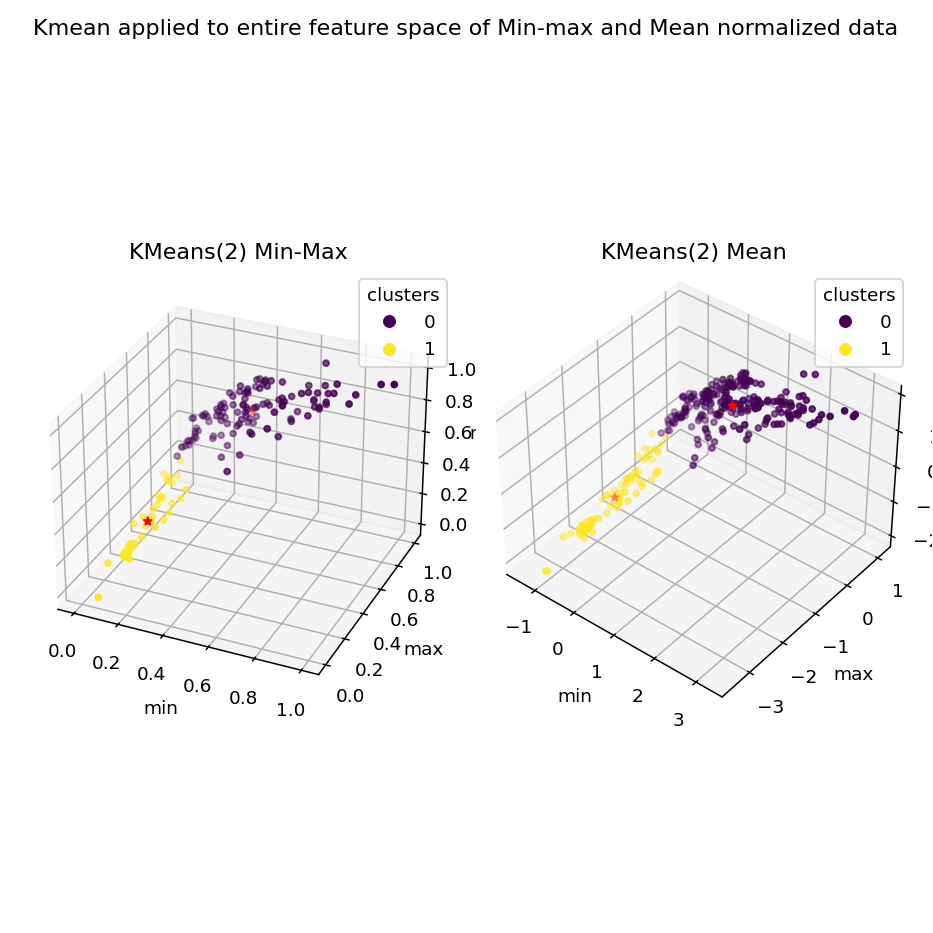

In [221]:
Kmeans_features_minmax = np.array(X_minmax_norm)
Kmeans_features_mean = np.array(Xm_mean_norm)
n_clusters = 2
kminmax = KMeans(n_clusters=n_clusters, random_state=0).fit(Kmeans_features_minmax)
kmean = KMeans(n_clusters=n_clusters, random_state=0).fit(Kmeans_features_mean)


fig = mpl.figure(figsize=(7,7))
#ax = mpl.axes(projection='3d', computed_zorder=False)
ax = fig.add_subplot(1, 2, 1, projection='3d', computed_zorder=False)
ax.scatter3D(kminmax.cluster_centers_[:, 0], kminmax.cluster_centers_[:, 1], kminmax.cluster_centers_[:, 2], s=20, c="r", marker='*', zorder=2, label="centroid")
s_plot1 = ax.scatter3D(Kmeans_features_minmax[:, 0], Kmeans_features_minmax[:, 1], Kmeans_features_minmax[:, 2], s=10, c=kminmax.labels_, zorder=1);
ax.set_xlabel("min"), ax.set_ylabel("max"), ax.set_zlabel("mean"), ax.set_title(f"KMeans({n_clusters}) Min-Max")
ax.legend(*s_plot1.legend_elements(), title='clusters', loc="best")

#ax = mpl.axes(projection='3d', computed_zorder=False)
ax = fig.add_subplot(1, 2, 2, projection='3d', computed_zorder=False)
ax.scatter3D(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], kmean.cluster_centers_[:, 2], s=20, c="r", marker='*', zorder=2, label="centroid")
s_plot2 = ax.scatter3D(Kmeans_features_mean[:, 0], Kmeans_features_mean[:, 1], Kmeans_features_mean[:, 2], s=10, c=kmean.labels_, zorder=1);
ax.set_xlabel("min"), ax.set_ylabel("max"), ax.set_zlabel("mean"), ax.set_title(f"KMeans({n_clusters}) Mean")
ax.legend(*s_plot2.legend_elements(), title='clusters', loc="best")
fig.suptitle("Kmean applied to entire feature space of Min-max and Mean normalized data")
mpl.tight_layout()
mpl.show()

In [ ]:
Kmeans_data = np.array([df_PCAm_minmax[PCA_names[0]].values, df_PCAm_minmax[PCA_names[1]].values, df_PCAm_minmax[PCA_names[2]].values]).T
n_clusters = 2
km = KMeans(n_clusters=n_clusters, random_state=0).fit(Kmeans_data)

mpl.figure()
ax = mpl.axes(projection='3d', computed_zorder=False)
s_plot = ax.scatter3D(Kmeans_data[:, 0], Kmeans_data[:, 1], Kmeans_data[:, 2], s=10, c=km.labels_, zorder=1);
ax.scatter3D(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2], s=20, c="r", marker='*', zorder=2, label="centroid")
ax.set_xlabel("pca1"), ax.set_ylabel("pca2"), ax.set_zlabel("pca3"), ax.set_title(f"KMeans({n_clusters})")
ax.legend(*s_plot.legend_elements(), title='clusters', loc="best")
mpl.show()

## Second way to mix the features

In [ ]:
mixed_features_df = []
for n_sat in prn:
    frames = []
    for i in range(len(features_df.loc[features_df["PRN"]==n_sat])):
        frames.append(features_df.loc[features_df["PRN"]==n_sat].iloc[i])
        frames.append(corrupted_features_df.loc[corrupted_features_df["PRN"]==n_sat].iloc[i])
        mixed_features_temp = pd.concat(frames,axis=1).transpose()
    mixed_features_df.append(mixed_features_temp)
    
mixed_features_df = pd.concat(mixed_features_df,ignore_index=True)
mixed_features_df

In [ ]:
Xm             = mixed_features_df.loc[:,mixed_features_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
Xm_minmax_norm =((Xm-Xm.min())/(Xm.max()-Xm.min())) # normalized X
# mean normalization
Xm_mean_norm   =(Xm-Xm.mean())/Xm.std()

# Apply PCA with all components and TSNE on mixed data
PCAm_minmax  = PCA().fit(Xm_minmax_norm)
PCAm_mean    = PCA().fit(Xm_mean_norm)
TSNEm_minmax = TSNE().fit(Xm_minmax_norm)
TSNEm_mean   = TSNE().fit(Xm_mean_norm)

# Recovered variance
recovered_var_minmax = np.cumsum(PCAm_minmax.explained_variance_ratio_)
recovered_var_mean   = np.cumsum(PCAm_mean.explained_variance_ratio_)
fig, ax = mpl.subplots(1,2)
ax[0].plot(np.linspace(0, len(recovered_var_minmax), len(recovered_var_minmax)), recovered_var_minmax, '.-')
ax[0].set_title("MinMax Normalization"), ax[0].set_ylabel("Recovered Variance"), ax[0].set_xlabel("# PCAs")
ax[1].plot(np.linspace(0, len(recovered_var_mean),   len(recovered_var_mean)), recovered_var_mean, '.-')
ax[1].set_title("Mean Normalization"),   ax[1].set_ylabel("Recovered Variance"), ax[1].set_xlabel("# PCAs")
fig.suptitle("Mixed Data Variance Reconstruction after Data Normalization")
mpl.tight_layout()

fig1, minmax_weight_df = plot_weight_matrix(PCAm_minmax, Xm_minmax_norm, "Min-Max Normalization Correlation Matrix Weights")
fig2, mean_weight_df = plot_weight_matrix(PCAm_mean, Xm_mean_norm, "Mean Normalization Correlation Matrix Weights")

# Apply PCA and TSNE on the optimal number of components
PCAm_minmax  = PCA(n_components=3).fit(Xm_minmax_norm)
PCAm_mean    = PCA(n_components=3).fit(Xm_mean_norm)
TSNEm_minmax = TSNE(n_components=3).fit(Xm_minmax_norm)
TSNEm_mean   = TSNE(n_components=3).fit(Xm_mean_norm)

features_PCAm_minmax  = PCAm_minmax.transform(Xm_minmax_norm)
features_PCAm_mean    = PCAm_mean.transform(Xm_mean_norm)
features_TSNEm_minmax = TSNE(n_components=3).fit_transform(Xm_minmax_norm)
features_TSNEm_mean   = TSNE(n_components=3).fit_transform(Xm_mean_norm)

print("Explained Variances for both normalization methods")
np.sum(PCAm_minmax.explained_variance_ratio_), np.sum(PCAm_mean.explained_variance_ratio_)

df_PCAm_minmax  = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
df_PCAm_mean    = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
df_TSNEm_minmax = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
df_TSNEm_mean   = pd.DataFrame({"PRN":list(mixed_features_df["PRN"])})
PCA_names       = list(PCAm_minmax.get_feature_names_out())

# PCA step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
for entry_minmax,entry_mean in zip(features_PCAm_minmax,features_PCAm_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean = np.append(data_x_mean,entry_mean[0])
    data_y_mean = np.append(data_y_mean,entry_mean[1])
    data_z_mean = np.append(data_z_mean,entry_mean[2])

df_PCAm_minmax[PCA_names[0]], df_PCAm_minmax[PCA_names[1]], df_PCAm_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_PCAm_mean[PCA_names[0]],   df_PCAm_mean[PCA_names[1]],   df_PCAm_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean
df_PCAm_minmax[PCA_names[0]], df_PCAm_minmax[PCA_names[1]], df_PCAm_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_PCAm_mean[PCA_names[0]],   df_PCAm_mean[PCA_names[1]],   df_PCAm_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean

# TSNE step
data_x_minmax, data_y_minmax, data_z_minmax = np.array([]), np.array([]), np.array([])
data_x_mean,   data_y_mean,   data_z_mean   = np.array([]), np.array([]), np.array([])
for entry_minmax,entry_mean in zip(features_TSNEm_minmax,features_TSNEm_mean):
    data_x_minmax = np.append(data_x_minmax,entry_minmax[0])
    data_y_minmax = np.append(data_y_minmax,entry_minmax[1])
    data_z_minmax = np.append(data_z_minmax,entry_minmax[2])
    
    data_x_mean = np.append(data_x_mean,entry_mean[0])
    data_y_mean = np.append(data_y_mean,entry_mean[1])
    data_z_mean = np.append(data_z_mean,entry_mean[2])

df_TSNEm_minmax[PCA_names[0]], df_TSNEm_minmax[PCA_names[1]], df_TSNEm_minmax[PCA_names[2]] = data_x_minmax, data_y_minmax, data_z_minmax
df_TSNEm_mean[PCA_names[0]],   df_TSNEm_mean[PCA_names[1]],   df_TSNEm_mean[PCA_names[2]]   = data_x_mean, data_y_mean, data_z_mean


fig = mpl.figure(figsize=(8,8))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(df_PCAm_minmax[PCA_names[0]], df_PCAm_minmax[PCA_names[1]], df_PCAm_minmax[PCA_names[2]]);
ax.set_xlabel(f'{PCA_names[0]}\n({PCAm_var_minmax[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCAm_var_minmax[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCAm_var_minmax[2]:.2f}%)')
ax.set_title('PCA of min-max normalized Feature Space')
ax.legend(loc="best")
x_minmax_loading, y_minmax_loading, z_minmax_loading = loading_plot(minmax_weight_df, ax)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter3D(df_PCAm_mean[PCA_names[0]], df_PCAm_mean[PCA_names[1]], df_PCAm_mean[PCA_names[2]], c='g');
ax.set_xlabel(f'{PCA_names[0]}\n({PCAm_var_mean[0]:.2f}%)'), 
ax.set_ylabel(f'{PCA_names[1]}\n({PCAm_var_mean[1]:.2f}%)'), 
ax.set_zlabel(f'{PCA_names[2]}\n({PCAm_var_mean[2]:.2f}%)')
ax.set_title('PCA of mean normalized Feature Space')
ax.legend(loc="best")
x_mean_loading, y_mean_loading, z_mean_loading = loading_plot(mean_weight_df, ax)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter3D(df_TSNEm_minmax[PCA_names[0]], df_TSNEm_minmax[PCA_names[1]], df_TSNEm_minmax[PCA_names[2]]);
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2]), 
ax.set_title(f"TSNE of min-max normalized Feature Space")
ax.legend(loc="best")

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D(df_TSNEm_mean[PCA_names[0]], df_TSNEm_mean[PCA_names[1]], df_TSNEm_mean[PCA_names[2]], c='g');
ax.set_xlabel(PCA_names[0]), ax.set_ylabel(PCA_names[1]), ax.set_zlabel(PCA_names[2])
ax.set_title(f"TSNE of mean normalized Feature Space")
fig.suptitle("Mixed Data PCA&TSNE Feature Decomposition")
mpl.tight_layout()
mpl.show()

## 2.a Polynomial Basis

In [40]:
def polynomial_decomposition(data, prn, threshold=1000):
    splitted_PR_idx = {}
    for n_sat in prn:
        splitting_index = []
        for i in range(data[n_sat]['tx_time'].shape[0]-1):
            if (data[n_sat]['tx_time'][i+1]-data[n_sat]['tx_time'][i] > threshold):
                splitting_index.append(i)
        splitted_PR_idx[n_sat] = splitting_index

    polyPRN = {}
    for n_sat in prn:
        i              = 0
        tempPoly1dList = []
        tempPoly1dCoef = []
        temptx_time    = []
        counter_idx    = 0
        for split_idx in splitted_PR_idx[n_sat]:
            tempPoly1d = np.poly1d(np.polyfit(data[n_sat]["tx_time"][counter_idx:split_idx].astype(np.float32),
                                              data[n_sat]["distance"][counter_idx:split_idx], 2))
            tempPoly1dList.append(tempPoly1d)
            tempPoly1dCoef.append(tempPoly1d.coef)
            temptx_time.append([counter_idx, split_idx])
            counter_idx = split_idx + 1

        tempPoly1d = np.poly1d(np.polyfit(data[n_sat]["tx_time"][counter_idx:-1].astype(np.float32),
                                          data[n_sat]["distance"][counter_idx:-1], 2))
        tempPoly1dList.append(tempPoly1d)
        tempPoly1dCoef.append(tempPoly1d.coef)
        temptx_time.append([counter_idx, len(data[n_sat]["tx_time"])-1])

        polyPRN[n_sat] = {"poly": tempPoly1dList, "coef": tempPoly1dCoef, "tx_idx": temptx_time}

    return splitted_PR_idx, polyPRN

## Polynomial decomposition for clean data and corrupted data

In [41]:
clean_splitted_idx, clean_polyPRN         = polynomial_decomposition(prn_dict, prn)
corrupted_splitted_idx, corrupted_polyPRN = polynomial_decomposition(corrupted_prn_dict, prn)
clean_splitted_idx, clean_polyPRN

/tmp/ipykernel_4042/3488863977.py:1: RankWarning: Polyfit may be poorly conditioned
  clean_splitted_idx, clean_polyPRN         = polynomial_decomposition(prn_dict, prn)
/tmp/ipykernel_4042/3488863977.py:2: RankWarning: Polyfit may be poorly conditioned
  corrupted_splitted_idx, corrupted_polyPRN = polynomial_decomposition(corrupted_prn_dict, prn)


({'G01': [19, 109],
  'G02': [65, 118, 184],
  'G03': [37, 127],
  'G04': [49, 74, 154, 179],
  'G05': [76, 106, 183],
  'G06': [61, 102, 175, 216],
  'G07': [75, 109, 185],
  'G08': [13, 98, 112],
  'G09': [68, 155],
  'G10': [45, 114, 160],
  'G11': [3, 90],
  'G12': [86],
  'G13': [88],
  'G14': [1, 60, 121, 180],
  'G15': [80, 95, 176],
  'G16': [26, 105, 132],
  'G17': [28, 81, 146, 199],
  'G19': [34, 90, 150, 206],
  'G20': [50, 115, 166],
  'G21': [30, 109, 140],
  'G22': [25, 115],
  'G24': [88],
  'G25': [88],
  'G26': [14, 97, 112],
  'G27': [87],
  'G28': [68, 117, 186],
  'G29': [18, 101, 120],
  'G30': [80, 100, 181],
  'G31': [16, 88, 128, 200]},
 {'G01': {'poly': [poly1d([2.20907695e-02, 5.35568860e+02, 2.22859989e+07]),
    poly1d([ 3.17158809e-02, -4.98127451e+03,  2.15888115e+08]),
    poly1d([ 3.09569245e-02, -1.02184984e+04,  8.63553622e+08])],
   'coef': [array([2.20907695e-02, 5.35568860e+02, 2.22859989e+07]),
    array([ 3.17158809e-02, -4.98127451e+03,  2.15888

<IPython.core.display.Javascript object>


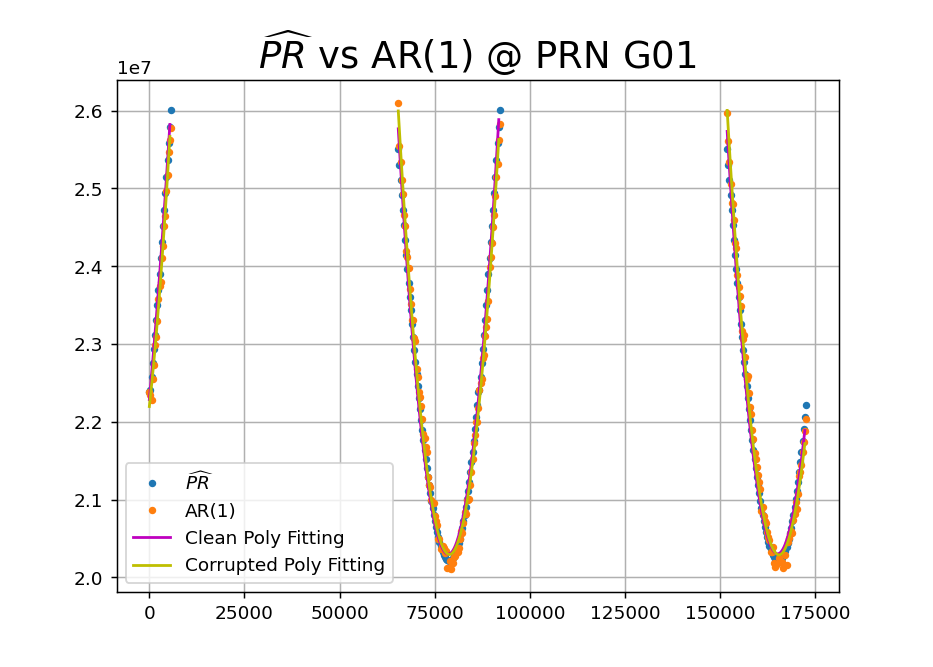

In [45]:
n_sat = "G01"

fig, ax = mpl.subplots(figsize=(7,5))
ax.plot(prn_dict[n_sat]["tx_time"], prn_dict[n_sat]["distance"], '.', linewidth=1)
ax.plot(prn_dict[n_sat]["tx_time"], corrupted_prn_dict[n_sat]["distance"], '.', linewidth=1)

for tx_idx, clean_poly, corrupted_poly in zip(clean_polyPRN[n_sat]["tx_idx"], clean_polyPRN[n_sat]["poly"], corrupted_polyPRN[n_sat]["poly"]): 
    ax.plot(prn_dict[n_sat]["tx_time"][tx_idx[0]:tx_idx[1]].astype(np.float32), clean_poly(prn_dict[n_sat]["tx_time"][tx_idx[0]:tx_idx[1]].astype(np.float32)), 'm')
    ax.plot(corrupted_prn_dict[n_sat]["tx_time"][tx_idx[0]:tx_idx[1]].astype(np.float32), corrupted_poly(corrupted_prn_dict[n_sat]["tx_time"][tx_idx[0]:tx_idx[1]].astype(np.float32)),'y') 
    
ax.set_title(r"$\widehat{PR}$"+f" vs AR({1}) @ PRN {n_sat}", size=20)
ax.legend([r"$\widehat{PR}$", f"AR(1)", "Clean Poly Fitting", "Corrupted Poly Fitting"],loc='best')
mpl.grid()
mpl.show()

In [43]:
clean_poly_df          = [] # clean pseudoranges feature-decomposed dataframe
corrupted_poly_df      = [] # corrupted pseudoranges feature-decomposed dataframe

for n_sat in prn: 
    # build clean dataframe from the clean dictionary for each visible PRN
    features_temp = pd.DataFrame.from_dict(clean_polyPRN[n_sat]["coef"])
    # insert the PRN column in the clean dataframe for each visible PRN
    features_temp.insert(0, 'PRN', n_sat)
    # concatenate clean dataframes
    clean_poly_df.append(features_temp)
    
    # build corrupted dataframe from the corrupted dictionary for each visible PRN
    corrupted_features_temp = pd.DataFrame.from_dict(corrupted_polyPRN[n_sat]["coef"])
    # insert the PRN column in the corrupted dataframe for each visible PRN
    corrupted_features_temp.insert(0, 'PRN', n_sat)
    # concatenate corrupted dataframes
    corrupted_poly_df.append(corrupted_features_temp)
    

# build the clean and corrputed dataframes separately by concatenating the dataframe for each PRN
clean_poly_df     = pd.concat(clean_poly_df, ignore_index=True)
corrupted_poly_df = pd.concat(corrupted_poly_df, ignore_index=True)
clean_poly_df.columns     = ["PRN", "c0", "c1", "c2"]
corrupted_poly_df.columns = ["PRN", "c0", "c1", "c2"]
clean_poly_df

PRN        c0            c1            c2
0    G01  0.022091    535.568860  2.228600e+07
1    G01  0.031716  -4981.274514  2.158881e+08
2    G01  0.030957 -10218.498353  8.635536e+08
3    G02  0.043054  -1008.483949  2.785593e+07
4    G02  0.043969  -3842.739146  1.073154e+08
..   ...       ...           ...           ...
102  G31  0.053557    128.769298  2.383179e+07
103  G31  0.044298  -4533.936492  1.370285e+08
104  G31  0.051895  -8841.064413  4.003229e+08
105  G31  0.044298 -12188.556238  8.594402e+08
106  G31  0.045862 -15767.276181  1.378964e+09

[107 rows x 4 columns]

<IPython.core.display.Javascript object>


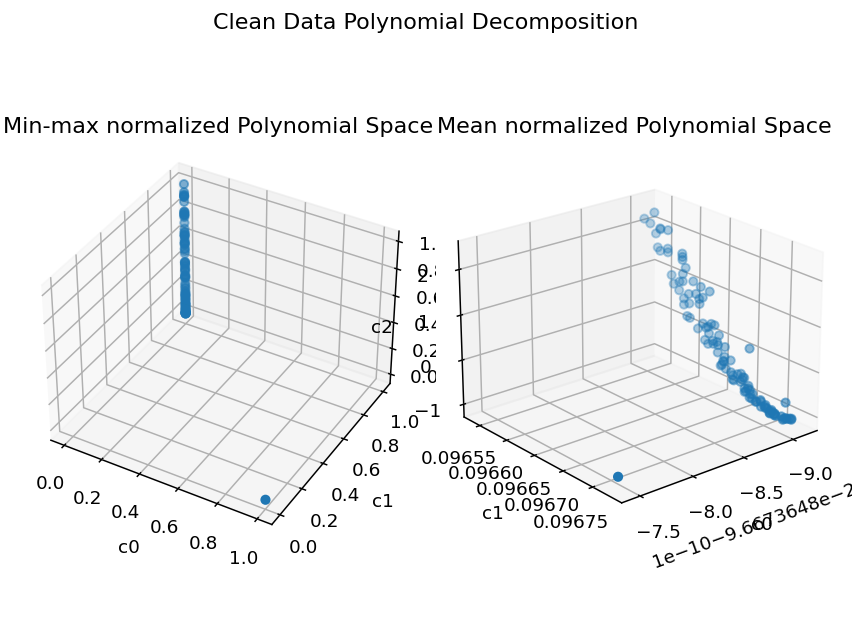

In [44]:
X             = clean_poly_df.loc[:,clean_poly_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
X_minmax_norm = ((X-X.min())/(X.max()-X.min())) # normalized X
# mean normalization
X_mean_norm   = (X-X.mean())/X.std()
coef_names    = list(X_minmax_norm.columns)

X_mean_norm = X_mean_norm[np.abs(X_mean_norm['c0']) < 2]
X_mean_norm = X_mean_norm[np.abs(X_mean_norm['c2']) < 3]

fig = mpl.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(X_minmax_norm[coef_names[0]], X_minmax_norm[coef_names[1]], X_minmax_norm[coef_names[2]]);
ax.set_xlabel(coef_names[0]), ax.set_ylabel(coef_names[1]), ax.set_zlabel(coef_names[2]), 
ax.set_title(f"Min-max normalized Polynomial Space")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X_mean_norm[coef_names[0]], X_mean_norm[coef_names[1]], X_mean_norm[coef_names[2]]);
ax.set_xlabel(coef_names[0]), ax.set_ylabel(coef_names[1]), ax.set_zlabel(coef_names[2]), 
ax.set_title(f"Mean normalized Polynomial Space")
fig.suptitle("Clean Data Polynomial Decomposition")
mpl.tight_layout()
mpl.show()

<IPython.core.display.Javascript object>


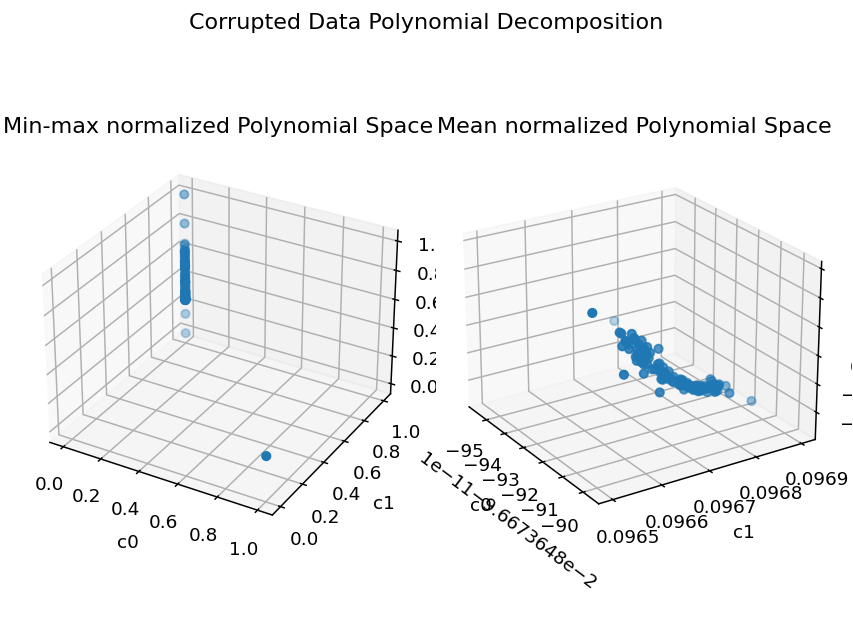

In [46]:
Xc             = corrupted_poly_df.loc[:,corrupted_poly_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
Xc_minmax_norm = ((Xc-Xc.min())/(Xc.max()-Xc.min())) # normalized X
# mean normalization
Xc_mean_norm   = (Xc-Xc.mean())/Xc.std()
coef_names    = list(Xc_minmax_norm.columns)

Xc_mean_norm = Xc_mean_norm[np.abs(Xc_mean_norm['c0']) < 2]
Xc_mean_norm = Xc_mean_norm[np.abs(Xc_mean_norm['c2']) < 3]

fig = mpl.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(Xc_minmax_norm[coef_names[0]], Xc_minmax_norm[coef_names[1]], Xc_minmax_norm[coef_names[2]]);
ax.set_xlabel(coef_names[0]), ax.set_ylabel(coef_names[1]), ax.set_zlabel(coef_names[2]), 
ax.set_title(f"Min-max normalized Polynomial Space")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Xc_mean_norm[coef_names[0]], Xc_mean_norm[coef_names[1]], Xc_mean_norm[coef_names[2]]);
ax.set_xlabel(coef_names[0]), ax.set_ylabel(coef_names[1]), ax.set_zlabel(coef_names[2]), 
ax.set_title(f"Mean normalized Polynomial Space")
fig.suptitle("Corrupted Data Polynomial Decomposition")
mpl.tight_layout()
mpl.show()

## Mix clean and corrupted data

In [47]:
mixed_poly_df = []
for n_sat in prn:
    frames = []
    for i in range(len(clean_poly_df.loc[clean_poly_df["PRN"]==n_sat])):
        frames.append(clean_poly_df.loc[clean_poly_df["PRN"]==n_sat].iloc[i])
        frames.append(corrupted_poly_df.loc[corrupted_poly_df["PRN"]==n_sat].iloc[i])
        mixed_poly_temp = pd.concat(frames,axis=1).transpose()
    mixed_poly_df.append(mixed_poly_temp)
    
mixed_poly_df = pd.concat(mixed_poly_df,ignore_index=True)
mixed_poly_df

PRN        c0            c1                 c2
0    G01  0.022091     535.56886    22285998.895866
1    G01  0.036771    444.327592    22197233.268337
2    G01  0.031716  -4981.274514   215888115.191435
3    G01   0.03166   -4990.90088   216984249.025724
4    G01  0.030957 -10218.498353   863553622.465542
..   ...       ...           ...                ...
209  G31  0.053017  -9065.876737   411318286.012176
210  G31  0.044298 -12188.556238   859440231.985952
211  G31  0.044647 -12308.163245    869257105.62502
212  G31  0.045862 -15767.276181  1378963671.949998
213  G31  0.056334 -19358.678503  1686872166.888487

[214 rows x 4 columns]

<IPython.core.display.Javascript object>


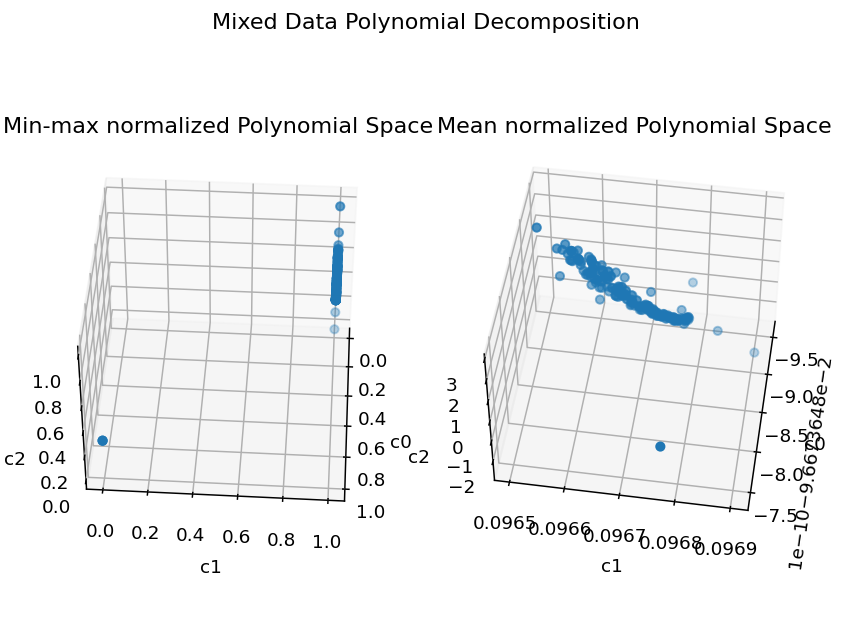

In [48]:
Xm             = mixed_poly_df.loc[:,mixed_poly_df.columns[1]:] # cut the PRN column from the dataframe
# min-max normalization
Xm_minmax_norm = ((Xm-Xm.min())/(Xm.max()-Xm.min())) # normalized X
# mean normalization
Xm_mean_norm   = (Xm-Xm.mean())/Xc.std()
coef_names    = list(Xm_minmax_norm.columns)

Xm_mean_norm = Xm_mean_norm[np.abs(Xm_mean_norm['c0']) < 2]
Xm_mean_norm = Xm_mean_norm[np.abs(Xm_mean_norm['c2']) < 3]

fig = mpl.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(Xm_minmax_norm[coef_names[0]], Xm_minmax_norm[coef_names[1]], Xm_minmax_norm[coef_names[2]]);
ax.set_xlabel(coef_names[0]), ax.set_ylabel(coef_names[1]), ax.set_zlabel(coef_names[2]), 
ax.set_title(f"Min-max normalized Polynomial Space")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Xm_mean_norm[coef_names[0]], Xm_mean_norm[coef_names[1]], Xm_mean_norm[coef_names[2]]);
ax.set_xlabel(coef_names[0]), ax.set_ylabel(coef_names[1]), ax.set_zlabel(coef_names[2]), 
ax.set_title(f"Mean normalized Polynomial Space")
fig.suptitle("Mixed Data Polynomial Decomposition")
mpl.tight_layout()
mpl.show()

In [ ]:
# Plot clean and corrupted with two different colors
# Try Poly Fitting for a pseudorange (windowing of 10 points)

## Polynomial fitting without normalization before and after polynomial fitting
## POlynomial fitting with normalization before and after polynomial fitting
## Combine both clean and corrupted datasets and plot them

## split pseudoranges for all sat
## apply feature based decomposition (PCA) & Kmeans
## apply poly decomposition & Kmeans
## dot his for nominal and corrupted pseudoranges

# TO BE REMOVED LATER

In [35]:
features_df = pd.DataFrame.from_dict(features, orient='index')
features_df

min  \
G01  [22382132.09915146, 24103944.921995156, 237844...   
G02  [24500940.236527186, 22912334.733911324, 21957...   
G03  [20696827.034731116, 21564321.28462724, 228941...   
G04  [20285964.016274557, 20328467.350191794, 21054...   
G05  [23935632.263657033, 22203604.020275425, 20887...   
G06  [22229215.301217698, 21012404.18940607, 207055...   
G07  [24021082.542071592, 22272918.628191404, 21125...   
G08  [25534127.69990388, 24776116.0481282, 23155718...   
G09  [20885009.002373982, 20201306.992077257, 20169...   
G10  [24405971.633722655, 23524258.588390697, 23462...   
G11  [24837993.11297986, 23007124.354502566, 214265...   
G12  [23618853.21392326, 21679790.276166487, 204278...   
G13  [24094264.263001908, 22498441.119306993, 21243...   
G14  [24727696.4423128, 23145246.153395068, 2236459...   
G15  [23723868.449552514, 22046447.757376608, 20756...   
G16  [24717728.163391504, 24637349.250444926, 24921...   
G17  [21770791.31181185, 22556683.473934427, 241072...   
G19  [21675962.22587706, 21963586.962728344, 232594...   
G20  [24151155.294639476, 23063127.260762203, 22904...   
G21  [25547086.787977148, 25360721.022013627, 25432...   
G22  [22147227.25180561, 23397271.580823563, 249370...   
G24  [23814724.64813883, 22176999.147645436, 209648...   
G25  [23644666.782182645, 21872626.34030226, 206827...   
G26  [25428127.032359827, 24895872.56890117, 232141...   
G27  [23938253.151334282, 22361556.05400414, 211492...   
G28  [23743879.231473036, 22203406.300248176, 21431...   
G29  [25331474.15339036, 25336380.17404027, 2348212...   
G30  [23927315.34881267, 22022937.50158796, 2073236...   
G31  [23859018.551106267, 24707815.356453687, 23220...   

                                                   max  \
G01  [23901089.30661563, 26010219.79568653, 2550631...   
G02  [26141677.257235967, 24325198.833334126, 22781...   
G03  [21451742.649185285, 22745821.817770347, 24358...   
G04  [20489984.608435698, 20946741.57374915, 222662...   
G05  [25596942.735180028, 23753359.303950835, 22047...   
G06  [23649598.14624108, 22075976.066444412, 209371...   
G07  [25727855.31317947, 23831987.70294503, 2212428...   
G08  [25695451.224818014, 25792713.652755033, 24608...   
G09  [22068267.914613858, 20776939.182415754, 20378...   
G10  [25894495.081987552, 24275174.66913125, 236915...   
G11  [25800890.245010555, 24647959.06270397, 228351...   
G12  [25654148.758475963, 23403484.485070344, 21518...   
G13  [25737573.214359526, 23922100.75352214, 223560...   
G14  [26079148.97151792, 24545487.70643595, 2302469...   
G15  [25376226.78025884, 23545887.053520564, 218954...   
G16  [25463516.053252768, 24848012.23695601, 255723...   
G17  [22434293.97443213, 23933878.429874223, 255949...   
G19  [21886855.741754524, 23094745.690129284, 24915...   
G20  [25763567.987126447, 24002324.14033328, 230200...   
G21  [26343180.80002343, 25495969.83844904, 2599852...   
G22  [23250744.60483044, 24804522.984667163, 258144...   
G24  [25541828.324735157, 23635293.480997853, 22034...   
G25  [25552401.515397537, 23446835.62349987, 217247...   
G26  [25627980.35306724, 25700029.70403175, 2472331...   
G27  [25585249.143495854, 23766915.19915745, 222223...   
G28  [25364913.805182736, 23569069.11421498, 220845...   
G29  [25748438.39651213, 25725732.27898727, 2547687...   
G30  [25798084.20451266, 23721587.504110705, 218596...   
G31  [24575916.326403618, 25658031.367812186, 24883...   

                                                  mean  \
G01  [23061150.155933432, 25050035.902679402, 24631...   
G02  [25317224.82046798, 23591687.15828411, 2231918...   
G03  [21022494.46080917, 22133634.48663961, 2361004...   
G04  [20357611.366949156, 20587403.523709554, 21631...   
G05  [24765619.14352507, 22963101.18667994, 2143019...   
G06  [22977896.614318363, 21497228.91542947, 207723...   
G07  [24878992.00438164, 23028093.830043018, 215760...   
G08  [25582236.704340145, 25401828.475580487, 23873...   
G09  [21488926.658753905, 20435568.947748564, 2

<IPython.core.display.Javascript object>


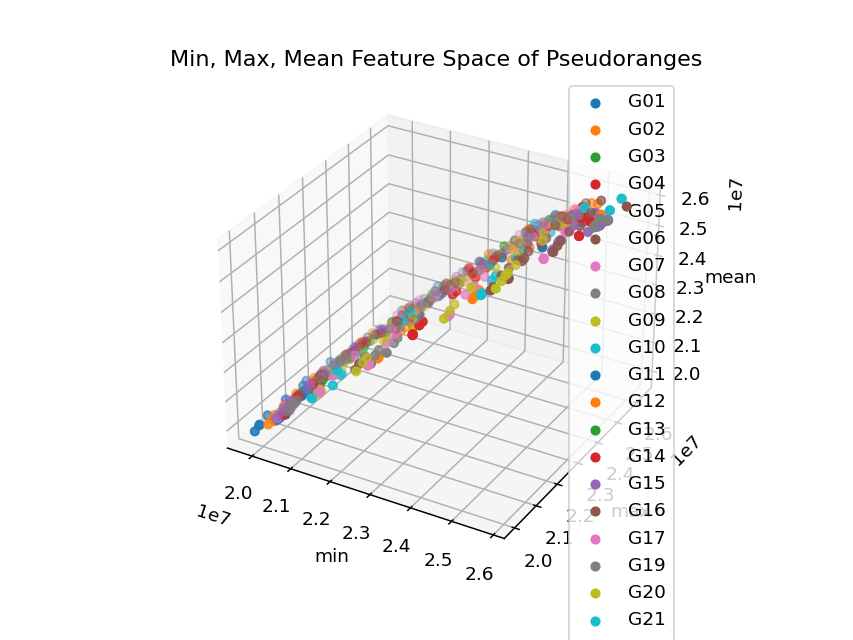

In [36]:
mpl.figure()
ax = mpl.axes(projection='3d')

data_x, data_y, data_z = np.array([]), np.array([]), np.array([])
for n_sat in prn:
    data_x = np.concatenate((data_x,features[n_sat]["min"]))
    data_y = np.concatenate((data_y,features[n_sat]["max"]))
    data_z = np.concatenate((data_z,features[n_sat]["mean"]))

    ax.scatter3D(features[n_sat]["min"], features[n_sat]["max"], features[n_sat]["mean"], label=n_sat);
ax.set_xlabel("min"), ax.set_ylabel("max"), ax.set_zlabel("mean"), ax.set_title("Min, Max, Mean Feature Space of Pseudoranges")
ax.legend(loc="best")
mpl.show()

## 1.b K-Means Clustering on Feature Basis

<IPython.core.display.Javascript object>


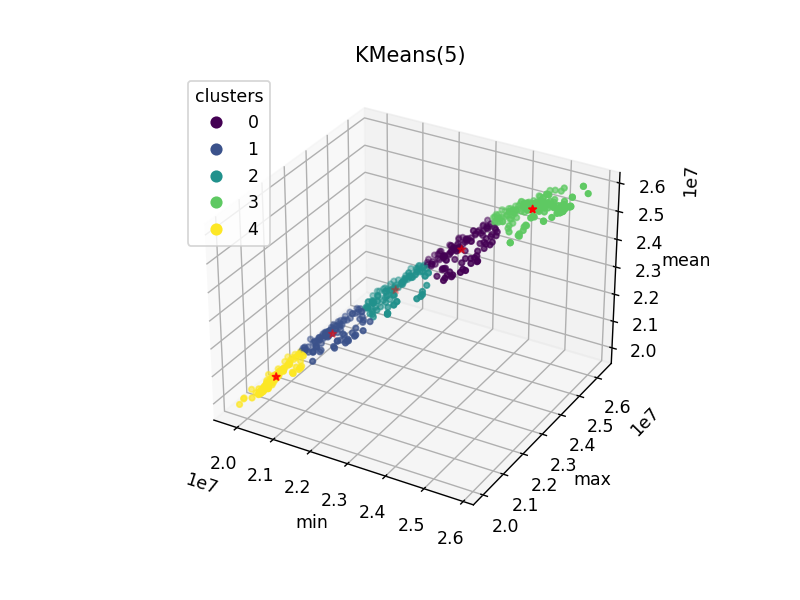

In [26]:
data = np.array([data_x, data_y, data_z]).T
n_clusters = 5
km = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

mpl.figure()
ax = mpl.axes(projection='3d', computed_zorder=False)
s_plot = ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], s=10, c=km.labels_, zorder=1);
ax.scatter3D(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2], s=20, c="r", marker='*', zorder=2, label="centroid")
ax.set_xlabel("min"), ax.set_ylabel("max"), ax.set_zlabel("mean"), ax.set_title(f"KMeans({n_clusters})")
ax.legend(*s_plot.legend_elements(), title='clusters', loc="best")

<IPython.core.display.Javascript object>


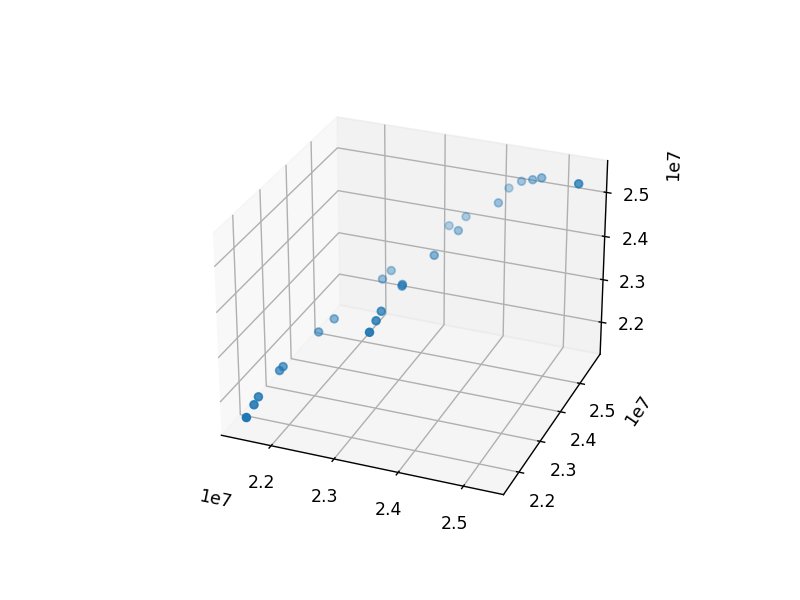

In [27]:
mpl.figure()
ax = mpl.axes(projection='3d')
n_sat="G20"
ax.scatter3D(features[n_sat]["min"], features[n_sat]["max"], features[n_sat]["mean"], label=n_sat);

[ 3.16585450e-02 -4.97256061e+03  2.15559510e+08]


<IPython.core.display.Javascript object>


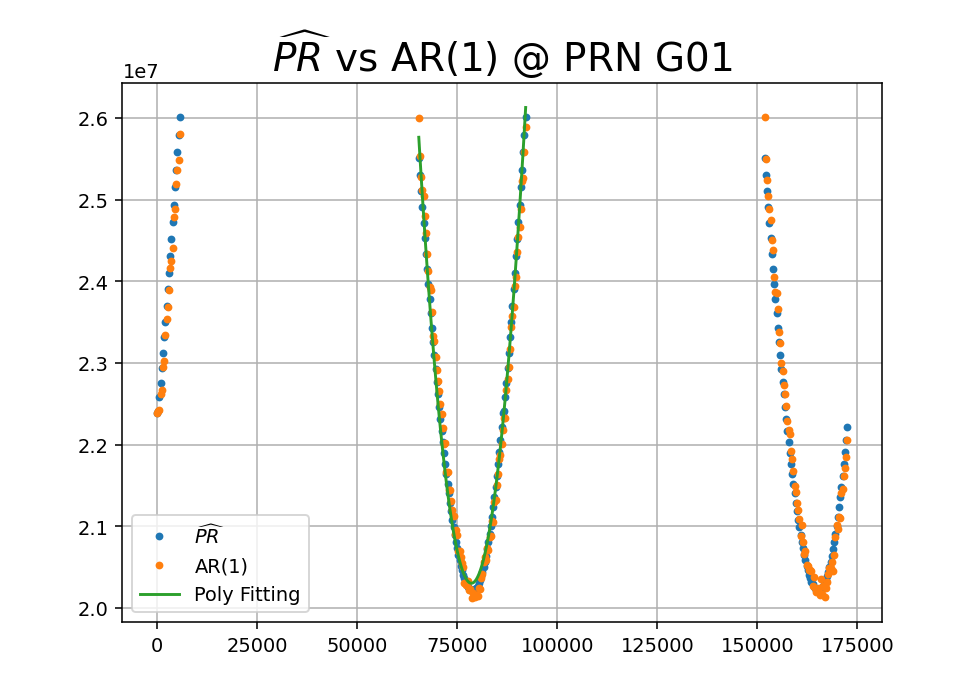

In [200]:
n_sat = "G01"
polyPRN1 = np.poly1d(np.polyfit(prn_dict[n_sat]["tx_time"][20:110].astype(np.float32), prn_dict[n_sat]["distance"][20:110], 2))
print(polyPRN1.coef)

fig, ax = mpl.subplots(figsize=(7,5))
ax.plot(prn_dict[n_sat]["tx_time"], prn_dict[n_sat]["distance"], '.', linewidth=1, label=r"$\widehat{PR}$")
ax.plot(prn_dict[n_sat]["tx_time"], corrupted_prn_dict[n_sat]["distance"], '.', linewidth=1, label=f"AR(1)")
#ax.set_xlim([0, 1000000])
ax.plot(prn_dict[n_sat]["tx_time"][20:110].astype(np.float32), polyPRN1(prn_dict[n_sat]["tx_time"][20:110].astype(np.float32)), label="Poly Fitting")
ax.set_title(r"$\widehat{PR}$"+f" vs AR({1}) @ PRN {n_sat}", size=20)
mpl.legend(loc='best')
mpl.grid()
mpl.show()

In [ ]:
timeObs = gr.gettime(obsFile)
timeNav = gr.gettime(navFile)

In [ ]:
obs['L1'].dropna(dim='time',how='all')

In [ ]:
OBS.data_vars["L1C"]

In [ ]:
NAV.coords["time"], NAV.coords["sv"]

In [ ]:
obs_df.values

In [ ]:
mpl.plot(obs_df.values)
mpl.show()

In [ ]:
obs_df["L1C"]